In [2]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")

In [234]:
# Functions
def CI(simulations, p):
    simulations = sorted(simulations, reverse=False)
    n = len(simulations)
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return(simulations[l_indx],simulations[u_indx])

class STRBias:
    def __init__(self, STR, Bias, Rank):
        self.STR = STR
        self.Bias = Bias
        self.Rank = Rank
        self.Boots = []
    def GetCI(self, p):
        return CI(self.Boots, p)

def LoadBiasData(ASD_Bias, ASD_Boot_Dir, asd_boot_dir):
    #ASD_Bias = pd.read_csv(ASD_Bias, index_col="STR")
    ASD_STR_Biases = {}
    for STR, row in ASD_Bias.iterrows():
        ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])

    for i in np.arange(1,1000,1):
        try:
            df = pd.read_csv("{}/bootstrap.{}.csv".format(ASD_Boot_Dir,i), index_col="STR")
        except:
            continue
        for STR, row in df.iterrows():
            ASD_STR_Biases[STR].Boots.append(row["EFFECT"])      
            
    biases_match_rank = {}
    biases_match_STR = {}
    for file in os.listdir(asd_boot_dir):
        df = pd.read_csv(asd_boot_dir+file, index_col="STR")
        for STR, row in df.iterrows():
            if STR not in biases_match_STR:
                biases_match_STR[STR] = []
            biases_match_STR[STR].append(row["EFFECT"])
            if row["Rank"] not in biases_match_rank:
                biases_match_rank[row["Rank"]] = []
            biases_match_rank[row["Rank"]].append(row["EFFECT"])
    return ASD_STR_Biases, biases_match_rank, biases_match_STR

def LoadSiblingBias(Sib_Bias, Sib_Boot_Dir):
    Sib_Bias = pd.read_csv(Sib_Bias, index_col="STR")
    Sib_STR_Biases = {}
    for STR, row in Sib_Bias.iterrows():
        Sib_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
        #print(Sib_STR_Biases[STR].Bias)

    for i in np.arange(1,1001,1):
        df = pd.read_csv("{}/bootstrap.{}.csv".format(Sib_Boot_Dir,i), index_col="STR")
        for STR, row in df.iterrows():
            Sib_STR_Biases[STR].Boots.append(row["EFFECT"])
    return Sib_STR_Biases

def PlotExpBias(ASD_STR_Biases, Sib_STR_Biases, biases_match_rank, 
                title="Structure Expression Bias of ASD vs Match"):
    fig, ax = plt.subplots(figsize=(6, 8), dpi=720)
    for i, (STR, STR_bias) in enumerate(sorted(ASD_STR_Biases.items(), key=lambda x:x[1].Rank)):
        upper, lower = STR_bias.GetCI(0.95)
        ax.hlines(i+1, lower, upper, color = "blue", lw=0.2)
        x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="blue")
        
    for i, (STR, STR_bias) in enumerate(sorted(Sib_STR_Biases.items(), key=lambda x:x[1].Rank)):
        upper, lower = STR_bias.GetCI(0.95)
        ax.hlines(i+1, lower, upper, color = "green", lw=0.2)
        x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="green")
        
    for i, (Rank, data) in enumerate(sorted(biases_match_rank.items(), key=lambda x:x[0])):
        upper, lower = CI(data, 0.95)
        ax.hlines(i+1 -0.3, lower, upper, color = "red", lw=0.2)
        x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="red")

    plt.gca().invert_yaxis()
    lgnd = ax.legend([x1, x2, x3], 
                     ["Proband Bias", "Sibling Bias", "Matched Bias"], 
                     prop={'size': 8})
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]
    lgnd.legendHandles[2]._sizes = [30]

    plt.title(title)
    plt.xlabel("Expression Bias")
    plt.ylabel("Structure Rank")
    plt.grid(True)
    return plt


In [198]:
Z1_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.csv", index_col="STR")
Z1_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1/"
Z1_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1/"
_Z1_Bias, _Z1_Match_Bias_Rank, _Z1_Match_Bias_STR = LoadBiasData(Z1_Bias,Z1_Boot_Dir,Z1_Match_Dir)

In [228]:
Z1_Sib = "dat/bias2/ASD.Siblings.z1.csv"
Z1_Sib_Boot = "dat/Bootstrap_Match/Sib.boot.Z1.bias/"
Z1_Sib = LoadSiblingBias(Z1_Sib, Z1_Sib_Boot)

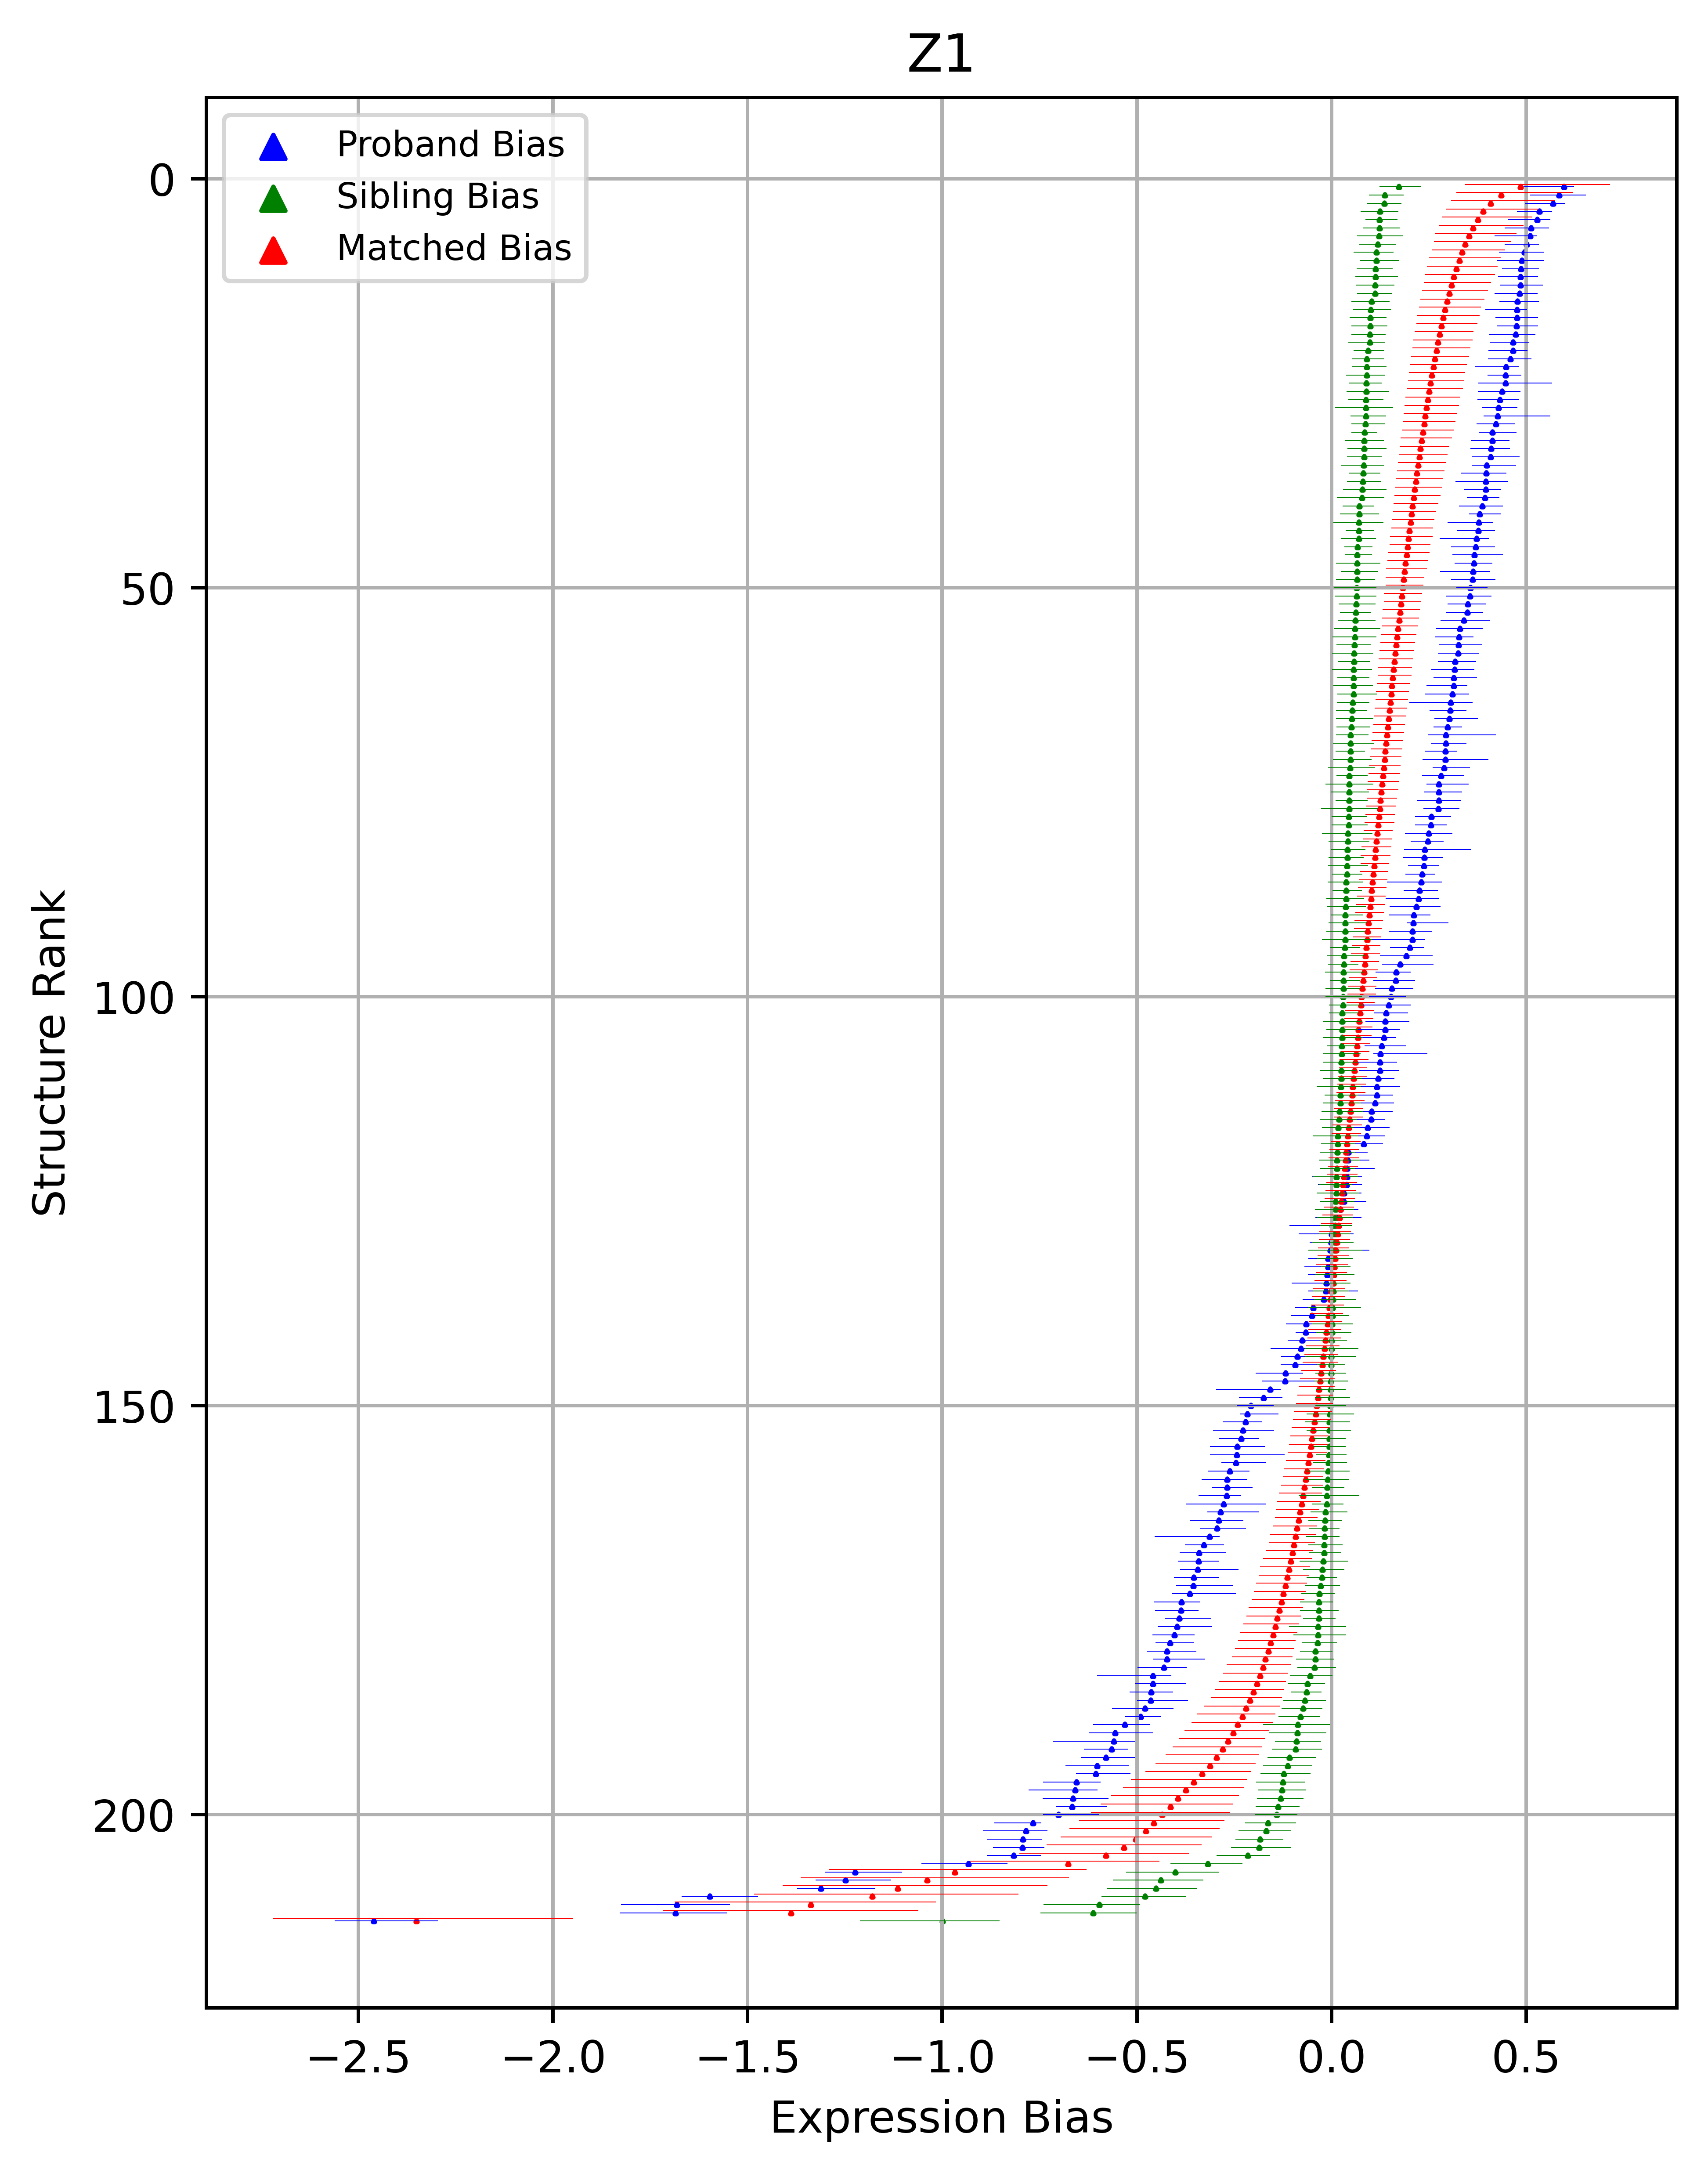

In [235]:
plt = PlotExpBias(_Z1_Bias, Z1_Sib, _Z1_Match_Bias_Rank, "Z1")

In [114]:
Z2_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.csv", index_col="STR")
Z2_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z2/"
Z2_Match_dir = "dat/Bootstrap_Match/asd.cont.bias.z2/"
_Z2_Bias, _Z2_Match_Bias_Rank, _Z2_Match_Bias_STR = LoadBiasData(Z2_Bias,Z2_Boot_Dir,Z2_Match_dir)

In [217]:
Z2_Sib = "dat/bias2/ASD.Siblings.z2.csv"
Z2_Sib_Boot = "dat/Bootstrap_Match/Sib.boot.Z2.bias/"
Z2_Sib = LoadSiblingBias(Z2_Sib, Z2_Sib_Boot)

0.1294081714925991
0.1287079948495983
0.117248620620653
0.103704796528983
0.1023244089187741
0.1018270351239274
0.0957448908828157
0.0955449824868387
0.0951614493841909
0.0926740237764208
0.0919668528587878
0.090722870583524
0.0905948696532489
0.0899345432946247
0.0887768087181533
0.0847771301122143
0.0820242540061644
0.0809234609794139
0.0793028765425317
0.0779967415692157
0.0726190562361829
0.071174209758201
0.0682546481425196
0.0664038201151435
0.0646358626985954
0.0621091826556708
0.0602140192903337
0.0584940619484228
0.0573756277912516
0.0569224702532559
0.0559114959786301
0.0547576520437788
0.0545289734736954
0.0541514806127348
0.0534733975680852
0.0498276533281707
0.049170632043812
0.048147373166198
0.0479681533584653
0.0476992207074035
0.0468623045391761
0.0435922445129287
0.0434660231303839
0.0434239563528555
0.0425001849519236
0.0417179774702483
0.0415722258266953
0.040685028784326
0.0404602600819458
0.0393605834034025
0.0387445301992993
0.0386526029328123
0.037264568100923
0

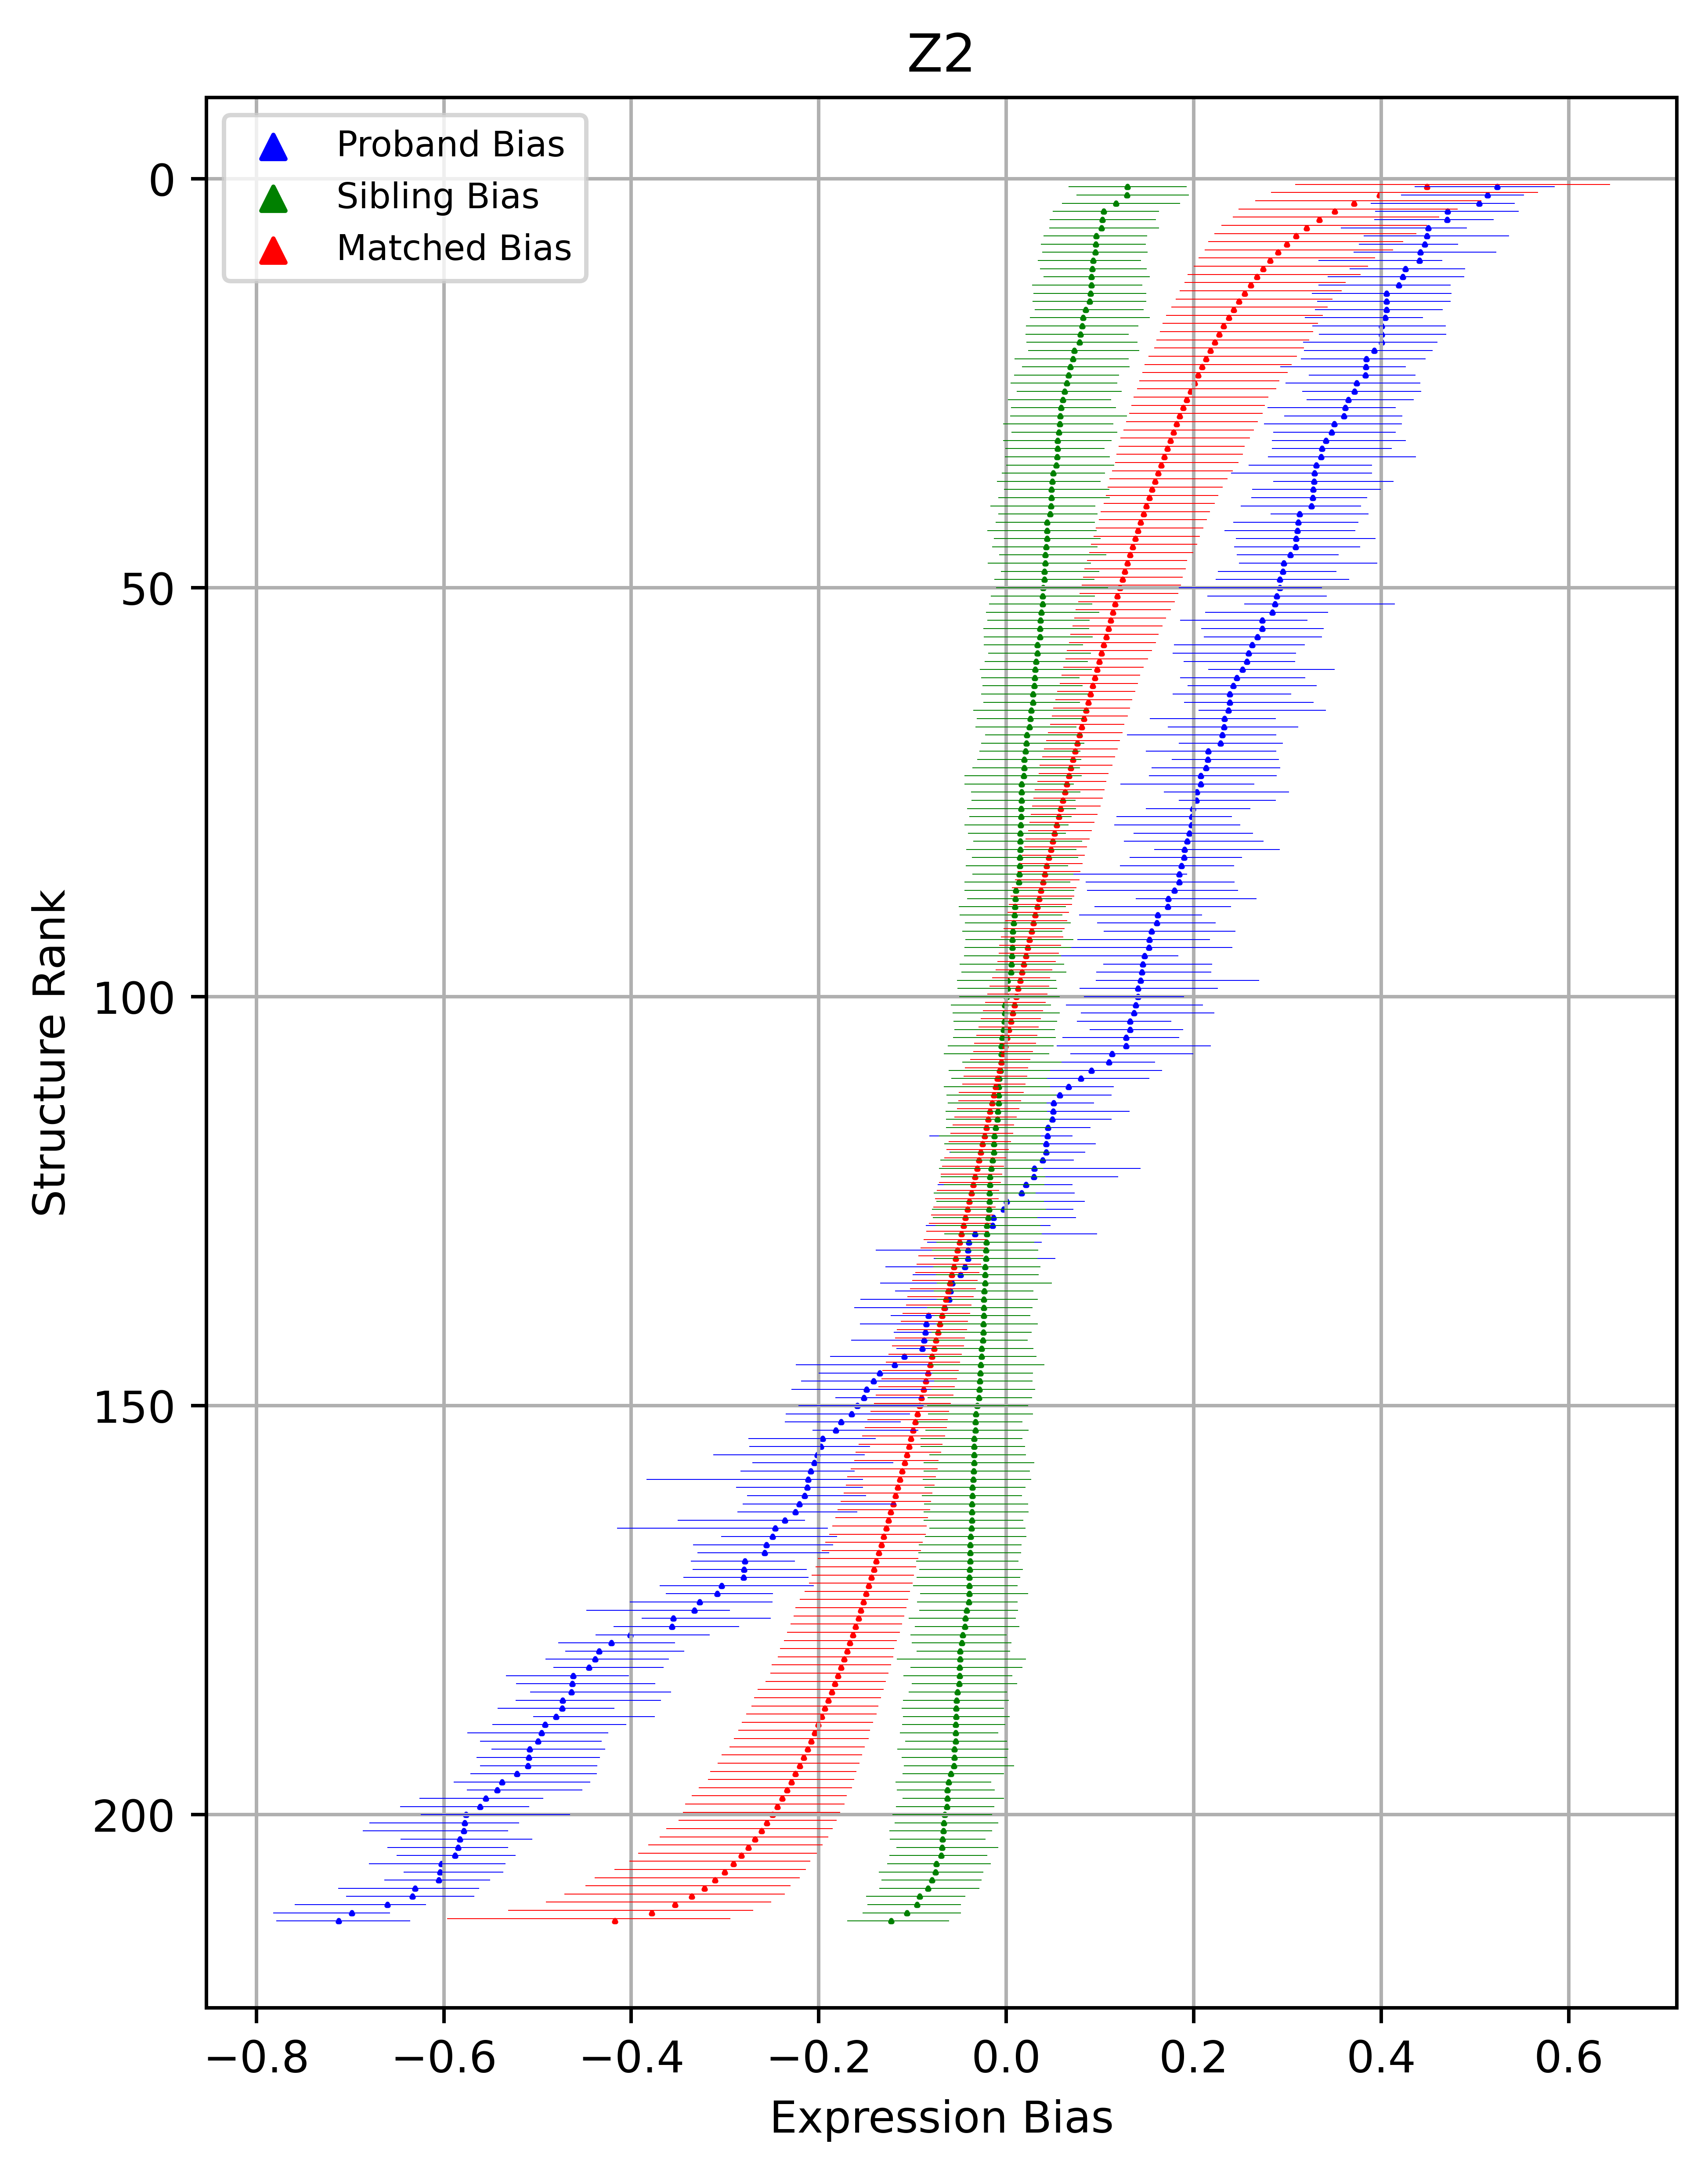

In [236]:
plt = PlotExpBias(_Z2_Bias, Z2_Sib, _Z2_Match_Bias_Rank, "Z2")

In [151]:
for STR, row in Z2_Bias.iterrows():
    #mat_bias = getBiasesBySTR(STR, match_dfs)
    mat_bias = _Z2_Match_Bias_STR[STR]
    Z, P = GetPermutationP(mat_bias, row["EFFECT"])
    print("%d %s %.3f %.3e" % (row["Rank"], STR, row["EFFECT"], P))
    Z2_Bias.loc[STR, "Z3"] = Z
    Z2_Bias.loc[STR, "Pvalue"] = P

1 Lateral_amygdalar_nucleus 0.524 3.000e-03
2 Orbital_area_lateral_part 0.514 1.000e-03
3 Prelimbic_area 0.504 1.000e-03
4 Dentate_gyrus 0.471 7.000e-03
5 Nucleus_accumbens 0.470 6.000e-03
6 Orbital_area_ventrolateral_part 0.450 4.000e-03
7 Anterior_pretectal_nucleus 0.449 6.000e-03
8 Basomedial_amygdalar_nucleus 0.447 2.000e-03
9 Lateral_posterior_nucleus_of_the_thalamus 0.442 2.000e-03
10 Infralimbic_area 0.441 7.000e-03
11 Intercalated_amygdalar_nucleus 0.426 5.000e-03
12 Endopiriform_nucleus_dorsal_part 0.423 2.000e-03
13 Claustrum 0.419 9.000e-03
14 Nucleus_of_reuniens 0.406 8.000e-03
15 Anterior_olfactory_nucleus 0.406 5.000e-03
16 Primary_somatosensory_area_lower_limb 0.406 7.000e-03
17 Dorsal_peduncular_area 0.404 9.000e-03
18 Field_CA3 0.401 1.500e-02
19 Subiculum_ventral_part 0.400 1.200e-02
20 Field_CA1 0.400 1.700e-02
21 Anteromedial_visual_area 0.392 9.000e-03
22 Parafascicular_nucleus 0.384 1.000e-02
23 Field_CA2 0.383 1.400e-02
24 Endopiriform_nucleus_ventral_part 0.383 

In [153]:
Z2_Bias.to_csv("dat/bias2/what.csv")

In [123]:
Z1_qn_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.qn.csv", index_col="STR")
Z1_qn_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1_qn/"
Z1_qn_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1_qn/"
_Z1_qn_Bias, _Z1_qn_Match_Bias_Rank, _Zq_qn_Match_Bias_STR = LoadBiasData(
    Z1_qn_Bias,Z1_qn_Boot_Dir,Z1_qn_Match_Dir)

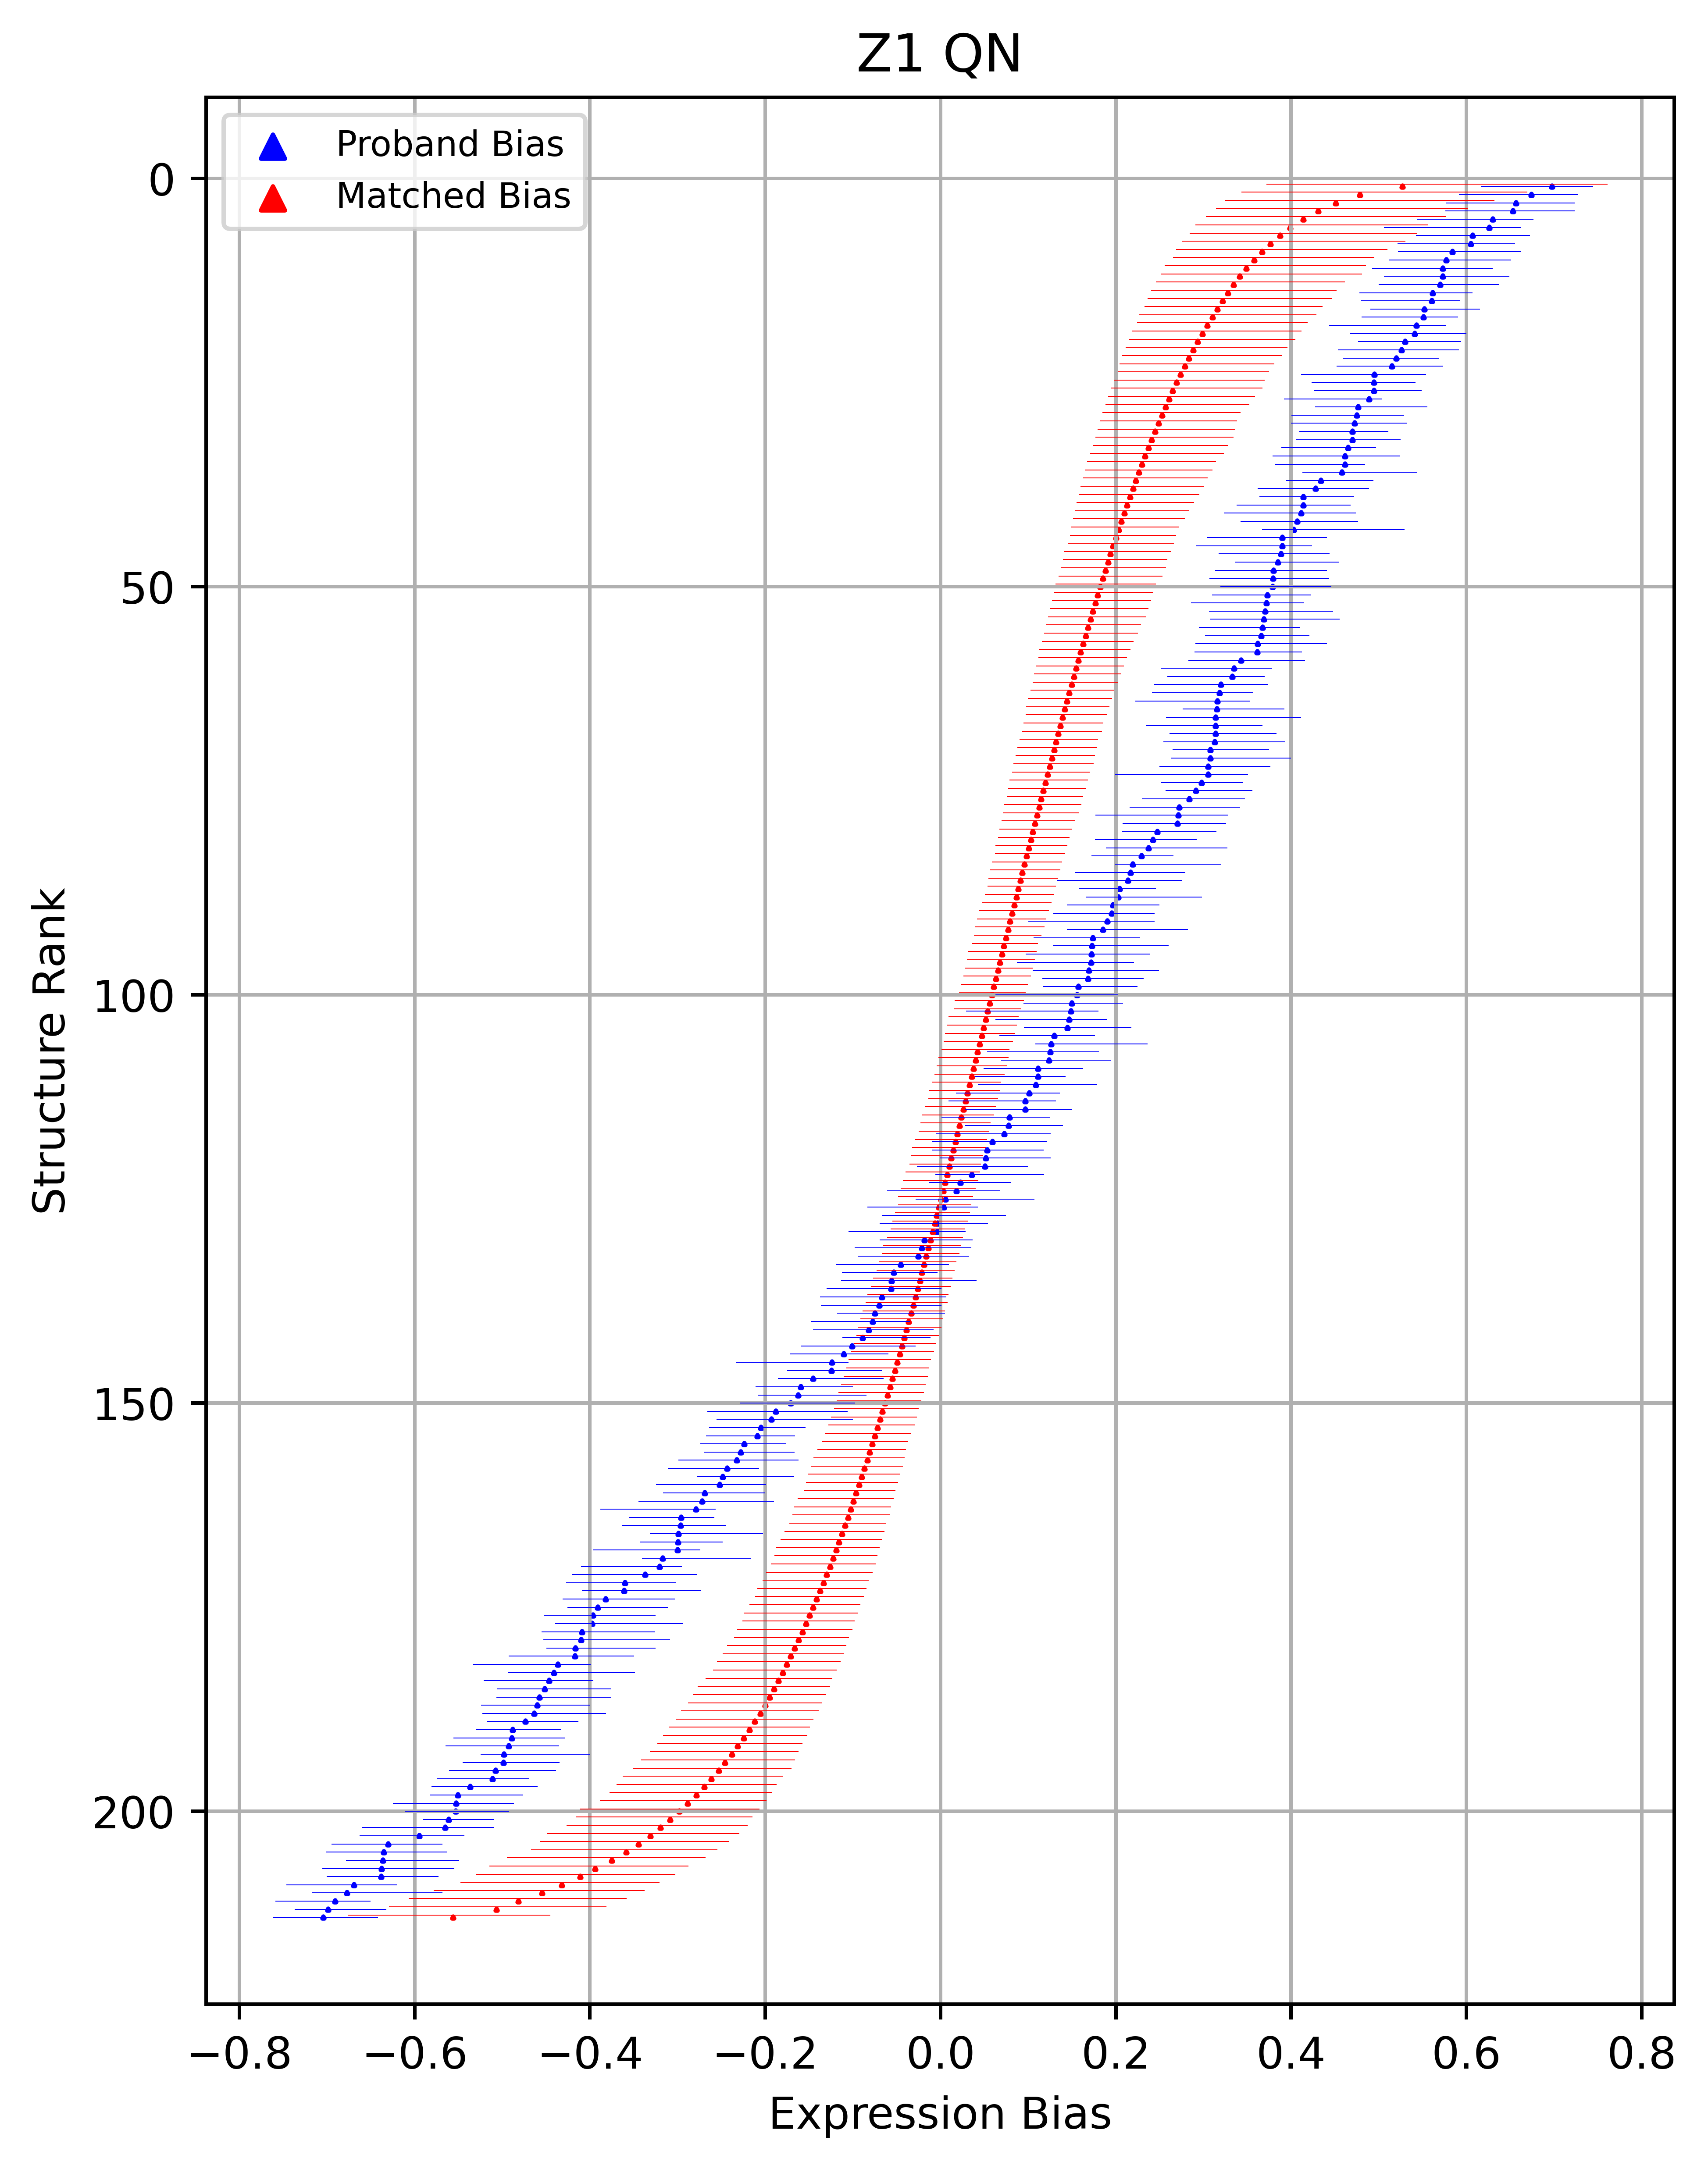

In [137]:
plt = PlotExpBias(_Z1_qn_Bias, _Z1_qn_Match_Bias_Rank, "Z1 QN")

In [128]:
Z1_Bias_ng = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.noneg.csv", index_col="STR")
Z1_ng_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1.noneg/"
Z1_ng_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1.noneg/"
_Z1_ng_Bias, _Z1_ng_Match_Bias_Rank, _Zq_ng_Match_Bias_STR = LoadBiasData(
    Z1_Bias_ng,Z1_ng_Boot_Dir,Z1_ng_Match_Dir)

In [230]:
Z1_Sib_ng = "dat/bias2/ASD.Siblings.z1.ng.csv"
Z1_Sib_ng_Boot = "dat/Bootstrap_Match/Sib.boot.Z1.bias.noneg/"
Z1_Sib_ng = LoadSiblingBias(Z1_Sib_ng, Z1_Sib_ng_Boot)

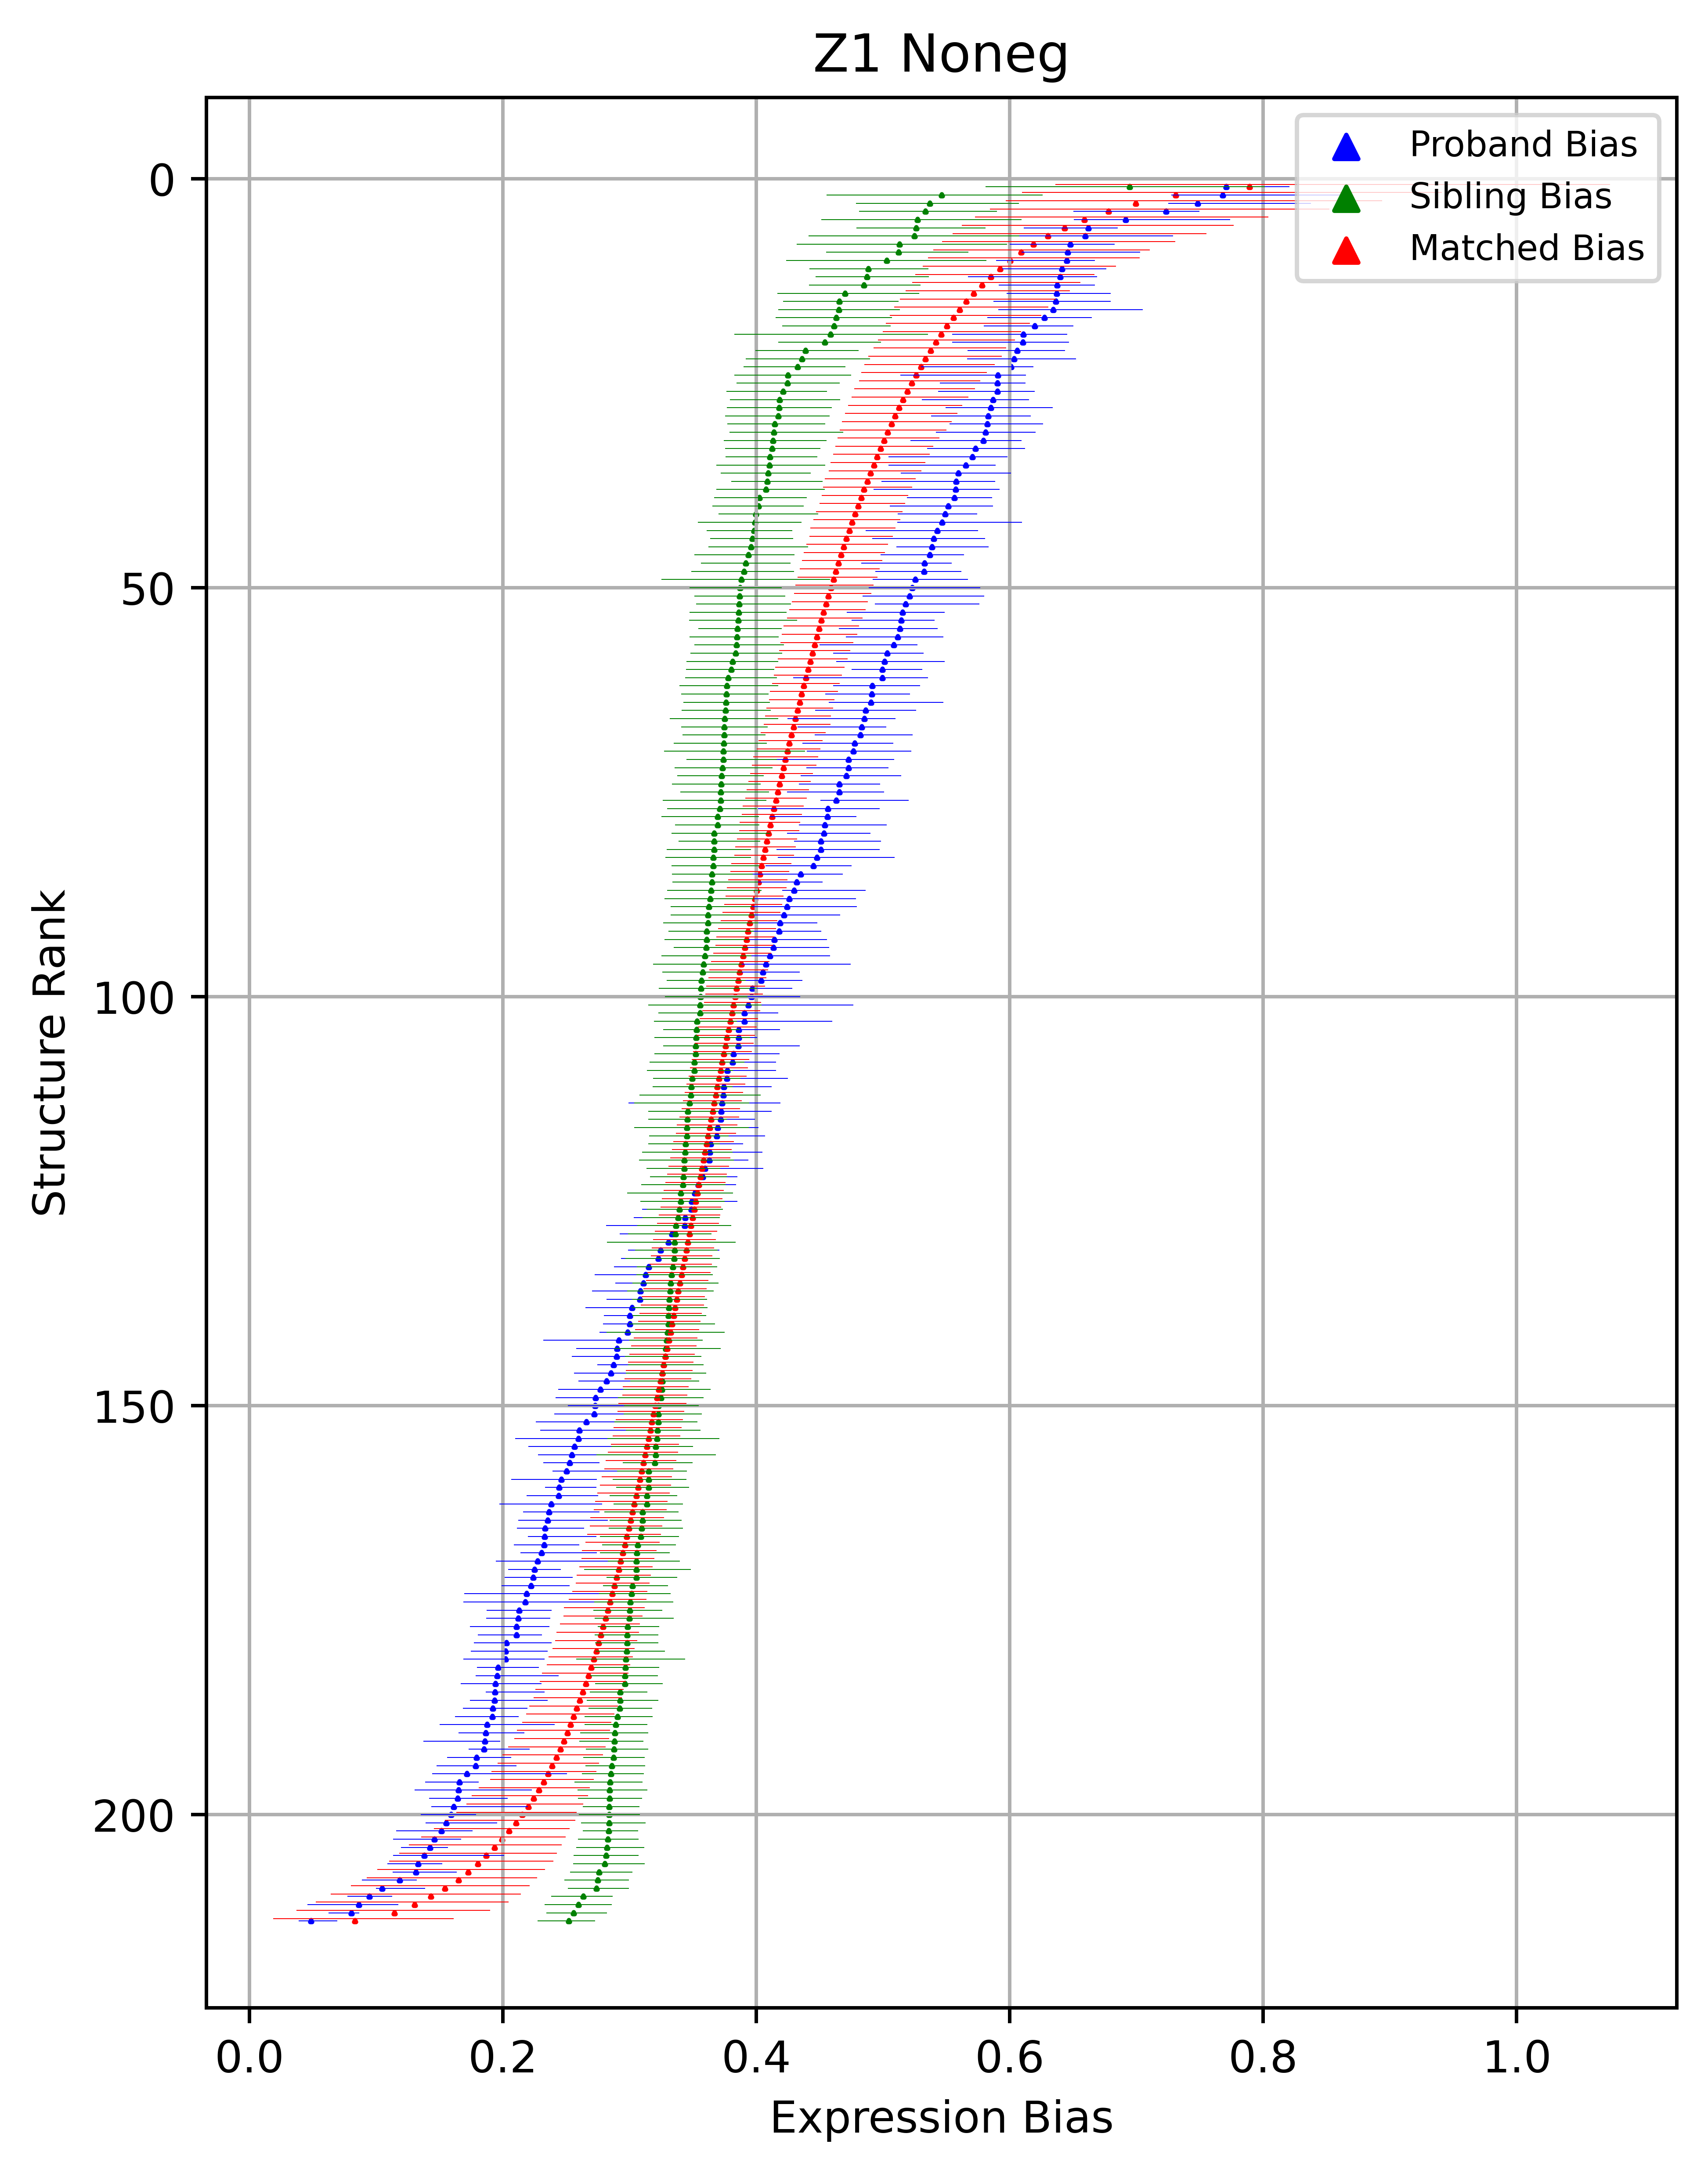

In [237]:
plt = PlotExpBias(_Z1_ng_Bias, Z1_Sib_ng, _Z1_ng_Match_Bias_Rank, "Z1 Noneg")

In [145]:
Z2_ng_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.noneg.csv", index_col="STR")
Z2_Boot_ng_Dir = "dat/Bootstrap_Match/asd.boot.bias.z2.noneg/"
Z2_Match_ng_dir = "dat/Bootstrap_Match/asd.cont.bias.z2.noneg/"
_Z2_ng_Bias, _Z2_ng_Match_Bias_Rank, _Z2_ng_Match_Bias_STR = LoadBiasData(
    Z2_ng_Bias,Z2_Boot_ng_Dir,Z2_Match_ng_dir)

In [225]:
Z2_Sib_ng = "dat/bias2/ASD.Siblings.z2.ng.csv"
Z2_Sib_ng_Boot = "dat/Bootstrap_Match/Sib.boot.Z2.bias.noneg/"
Z2_Sib_ng = LoadSiblingBias(Z2_Sib_ng, Z2_Sib_ng_Boot)

0.4846254663918372
0.4702806408258512
0.4577940881932757
0.4507011288192381
0.4505181913852132
0.4471484371681365
0.4429748030632616
0.4427571802240564
0.438356159392794
0.4376821070170836
0.4346416482979606
0.4339804010504263
0.4331989622679001
0.4327715462029053
0.4322931132004141
0.429045859124525
0.4272196117057371
0.4252808078995464
0.4247765142188514
0.424435938120865
0.4233836161323972
0.4227903611237226
0.4212725072339591
0.4201123953246418
0.4189242881441721
0.4187861142940794
0.416627158183444
0.4164886411079568
0.4157104248110876
0.4153735795173059
0.4147424737185002
0.4143435573642738
0.4140972922006558
0.412990592480763
0.4128228757399159
0.4122454972011666
0.4119349626753108
0.4115348967429758
0.4109150482111475
0.4107890530160023
0.4098321346796693
0.4089907928245331
0.4084501380657693
0.4082964399903333
0.4082265627961222
0.4078986168142764
0.4077520397324291
0.4074631668570777
0.4073659468492734
0.4071164889733434
0.4069494807187259
0.4059008698456919
0.405821674460492

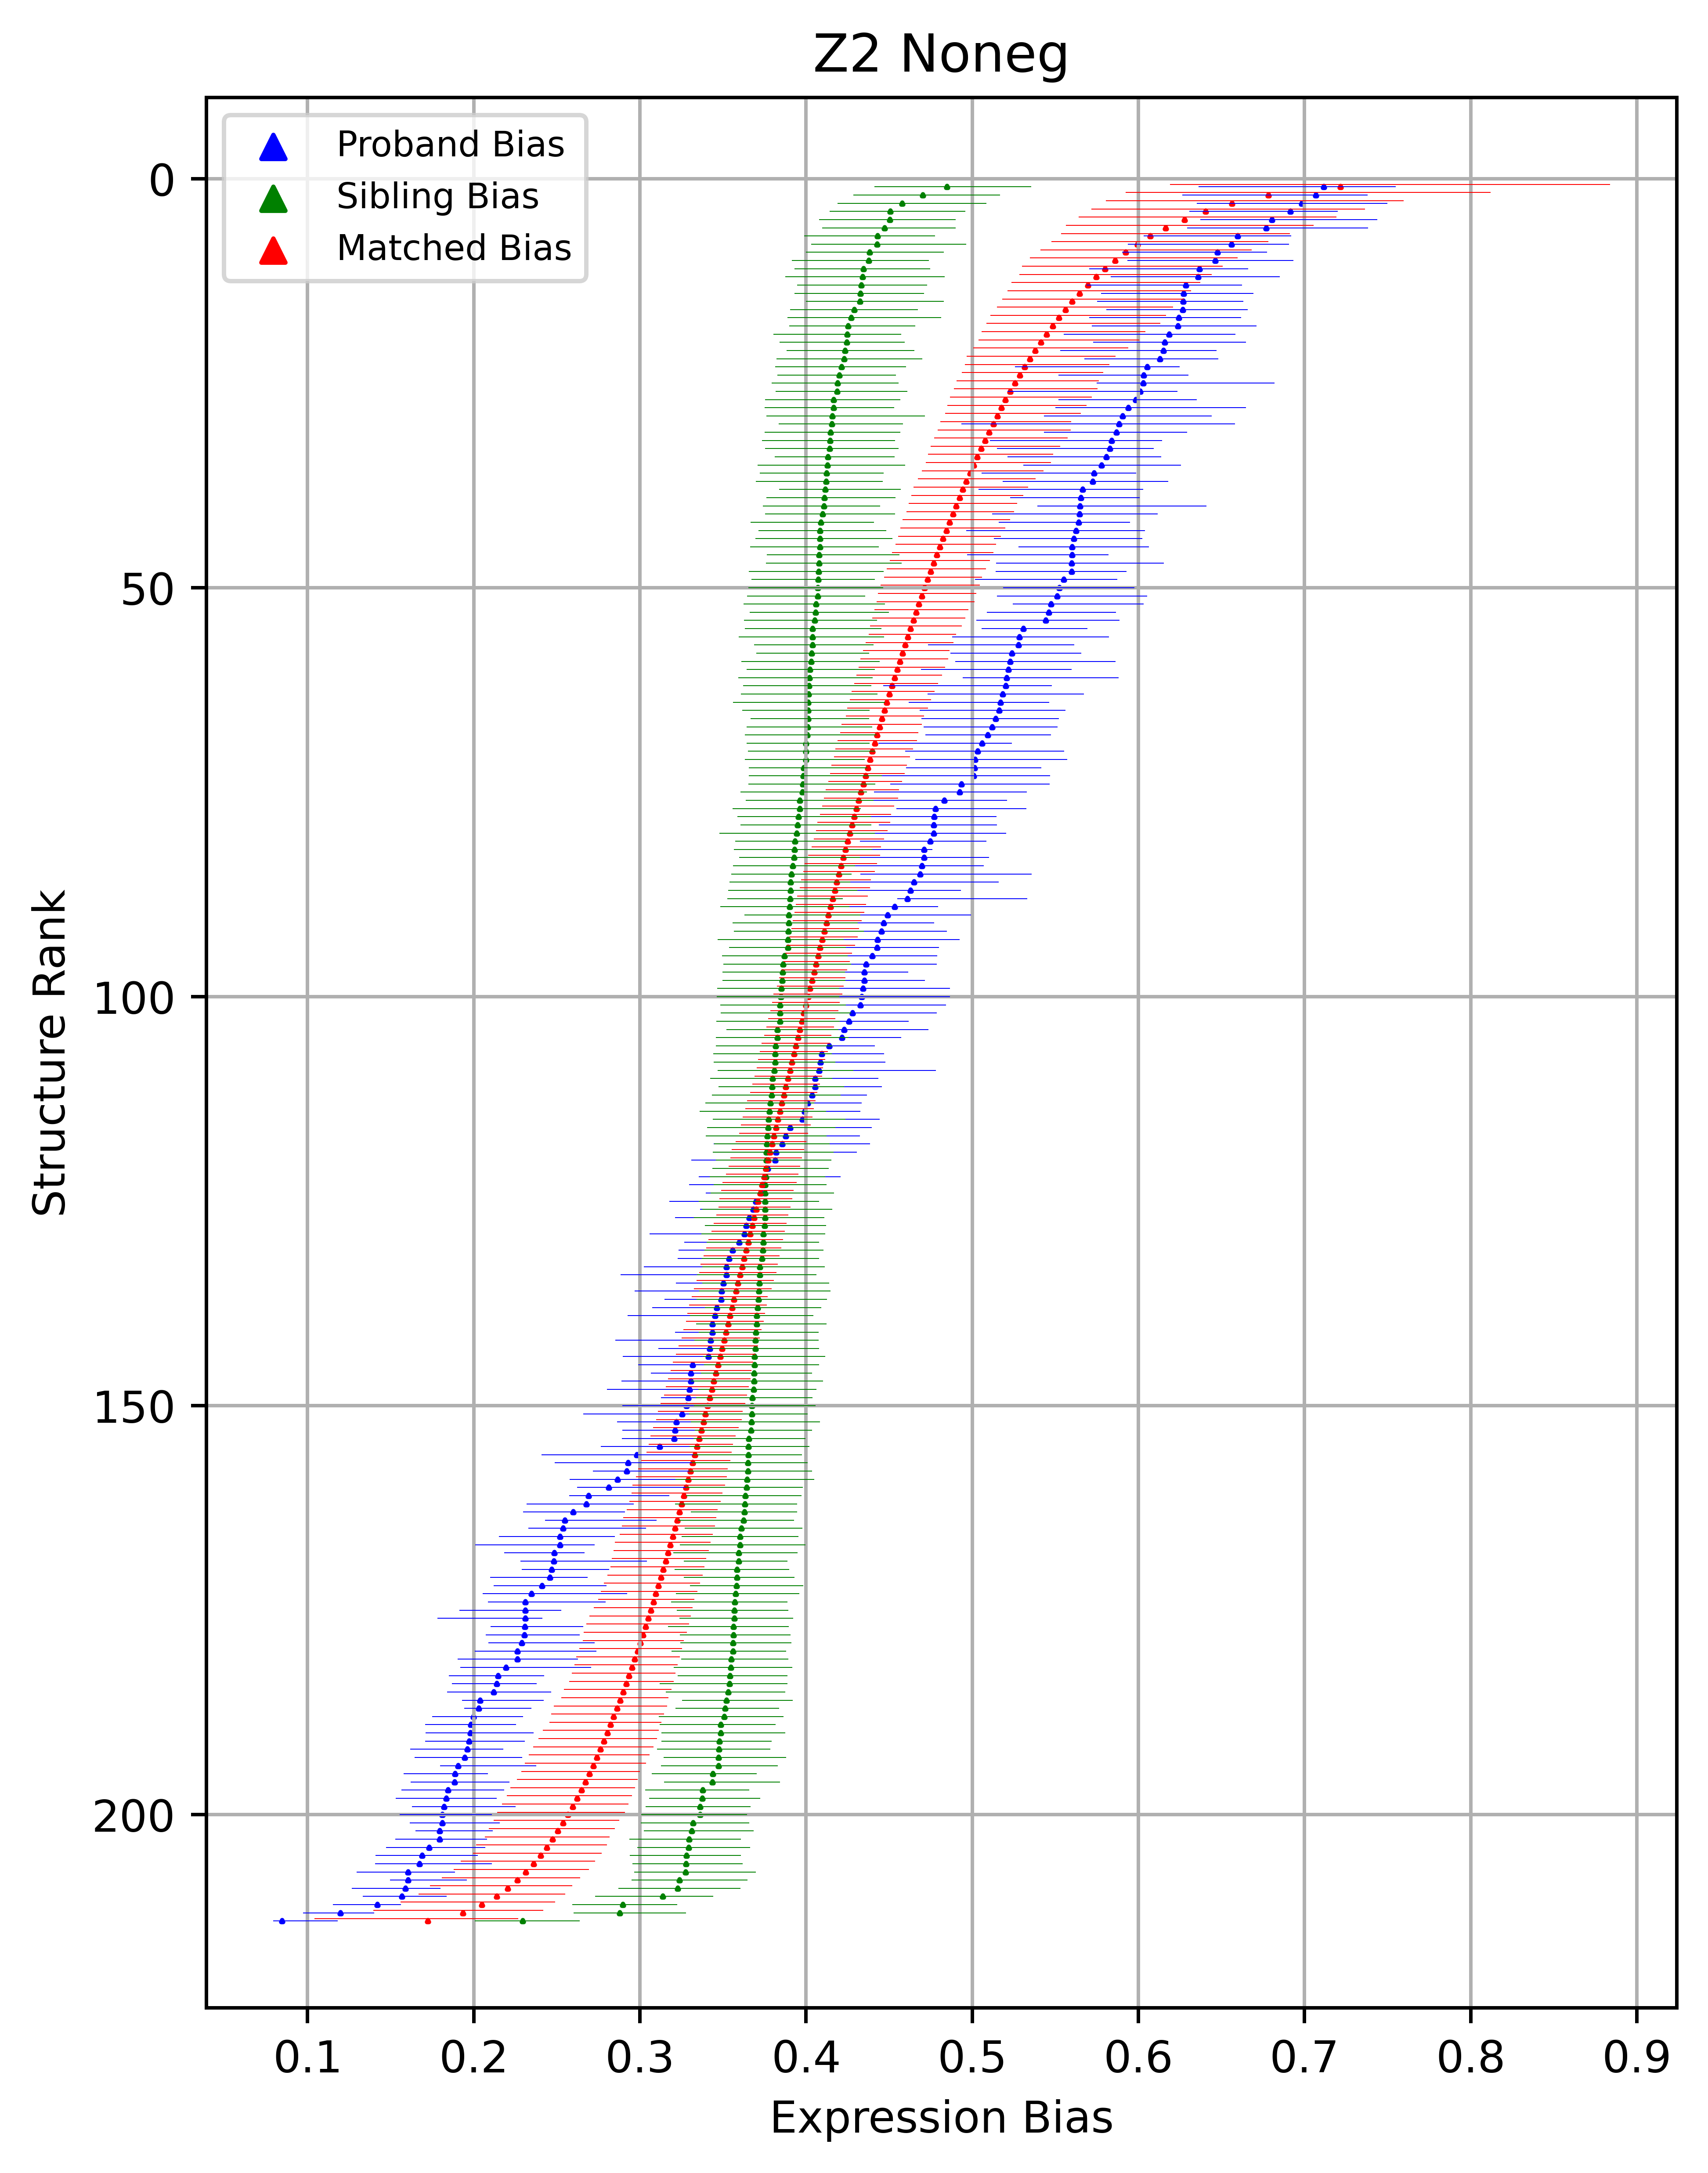

In [238]:
plt = PlotExpBias(_Z2_ng_Bias, Z2_Sib_ng, _Z2_ng_Match_Bias_Rank, "Z2 Noneg")

In [131]:
Z1_qn_ng_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.qn.ng.csv", index_col="STR")
Z1_qn_ng_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1_qn.noneg/"
Z1_qn_ng_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1_qn.noneg/"
_Z1_qn_ng_Bias, _Z1_qn_ng_Match_Bias_Rank, _Zq_qn_ng_Match_Bias_STR = LoadBiasData(
    Z1_qn_ng_Bias,Z1_qn_ng_Boot_Dir,Z1_qn_ng_Match_Dir)

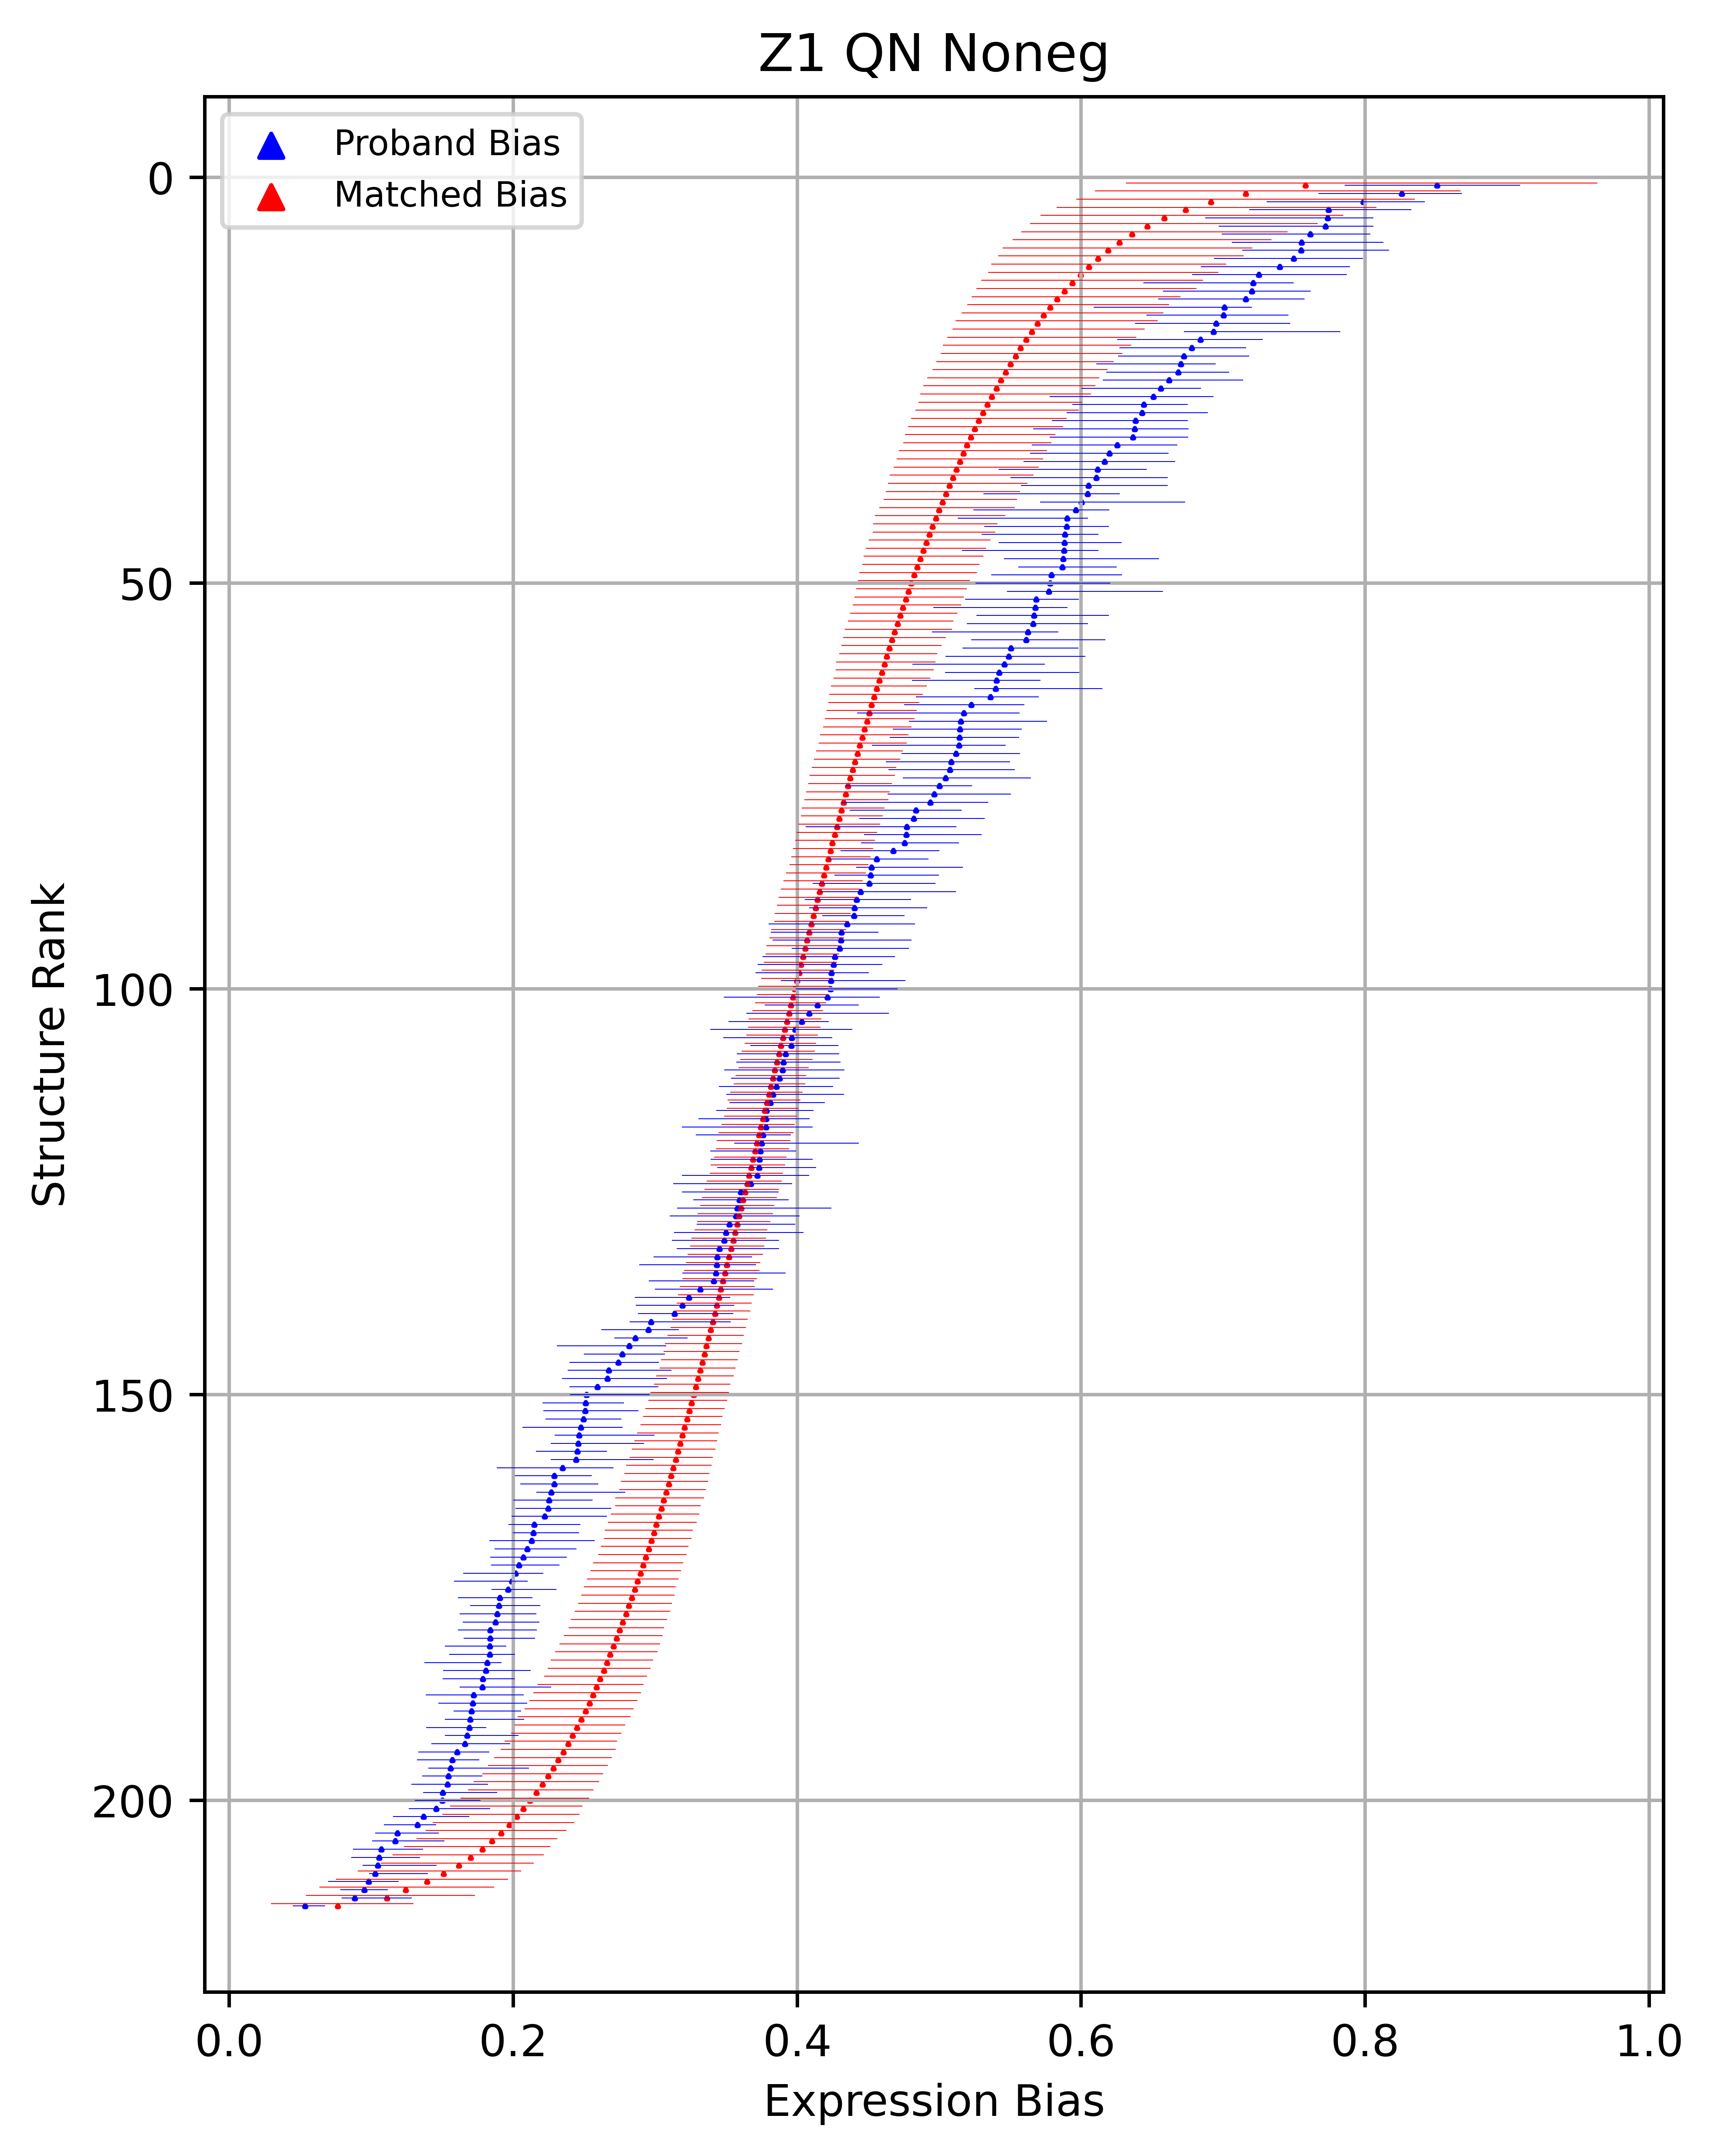

In [148]:
plt = PlotExpBias(_Z1_qn_ng_Bias, _Z1_qn_ng_Match_Bias_Rank, "Z1 QN Noneg")

# Anly Z1 and Z2

##### 0. Construct Z2 matrix

In [4]:
Z2_DIR = "dat/Z2scores/"
DFs = []
for file in os.listdir(Z2_DIR):
    df = pd.read_csv(Z2_DIR+file, index_col=0)
    DFs.append(df)

In [24]:
Z2DF = pd.concat(DFs)
Z2DF.to_csv("dat/z2.all.genes.str.mat.csv")

##### correlation of STR

In [21]:
def comparebias(DF1, DF2, STR, genes=[]):
    X, Y = [], []
    if len(genes) == 0:
        genes = DF1.index.values
    for idx in genes:
        try:
            x = DF1.loc[idx, STR]
            y = DF2.loc[idx, STR]
            if x == x and y==y:
                X.append(x)
                Y.append(y)
        except:
            continue
    return pearsonr(X,Y)

In [13]:
Rs = []
for STR in Z2DF.columns.values:
    r,p = comparebias(Z2DF, ExpZscoreMat, STR)
    Rs.append(r)

(array([ 4.,  0.,  5., 10., 11., 13., 17., 47., 51., 55.]),
 array([0.95409976, 0.95838778, 0.9626758 , 0.96696382, 0.97125185,
        0.97553987, 0.97982789, 0.98411591, 0.98840393, 0.99269195,
        0.99697998]),
 <BarContainer object of 10 artists>)

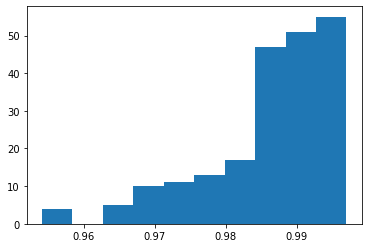

In [15]:
plt.hist(Rs)

In [18]:
# Among ASD genes
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]

In [19]:
Spark_Meta_ExomeWide

,GeneID,EntrezID,HGNC,CytoBand,ExACpLI,LoFOvsE,LOEUF,LOEUFbin,SynOvsE,sHet,...,AllExpected_NDD,pAllEnrich_NDD,MisObserved_NDD,MisExpected_NDD,pMisEnrich_NDD,MisEvents_NDD,MisDist_NDD,pMisCluster_NDD,pMisComb_NDD,pDenovoWEST_NDD
0,ENSG00000143442,23126,POGZ,1q21.3,1,0.045859,0.119,0,0.97057,0.214955,...,0.934605,0.0,2.44,0.601588,0.00168,9,550.2,0.03,0.000571,0.0
1,ENSG00000169057,4204,MECP2,Xq28,0.69809,0.085755,0.407,1,2.02820,0.088203,...,0.18052,0.0,9.24,0.124697,0.0,44,131.4,0.0,0.0,0.0
2,ENSG00000136531,6326,SCN2A,2q24.3,1,0.060487,0.127,0,1.00840,0.257771,...,1.884194,0.0,34.18,1.474638,0.0,58,1106.6,0.00247,0.0,0.0
3,ENSG00000171862,5728,PTEN,10q23.31,0.97551,0.240930,0.507,2,1.01830,0.12616,...,0.365588,0.0,14.1,0.273796,0.0,20,178.5,0.00542,0.0,0.0
4,ENSG00000173575,1106,CHD2,15q26.1,1,0.027031,0.070,0,0.95212,0.172054,...,1.615307,0.0,8.78,1.11824,0.0,13,410.8,0.000024,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,ENSG00000158321,26053,AUTS2,7q11.22,0.99619,0.134640,0.253,0,1.08100,0.067271,...,0.958668,0.0,0.63,0.719486,1,3,698.6,0.3,0.66,0.0
115,ENSG00000108557,10743,RAI1,17p11.2,0.99914,0.036788,0.116,0,1.16930,0.012328,...,1.153482,0.0,1.05,0.858245,0.39,5,1580,0.67,0.61,0.0
116,ENSG00000103197,7249,TSC2,16p13.3,1,0.023406,0.074,0,1.48200,0.096255,...,1.148531,0.000036,1.89,0.826876,0.02,9,1740.2,0.99,0.1,0.000036
120,ENSG00000163625,23001,WDFY3,4q21.23,1,0.037990,0.071,0,1.01720,0.149233,...,2.470801,0.00852,1.81,1.61981,0.37,6,2851,0.66,0.59,0.00852


(array([  1.,   1.,   1.,   1.,   2.,   9.,  11.,  22.,  54., 111.]),
 array([0.95677257, 0.96098444, 0.9651963 , 0.96940817, 0.97362003,
        0.97783189, 0.98204376, 0.98625562, 0.99046749, 0.99467935,
        0.99889121]),
 <BarContainer object of 10 artists>)

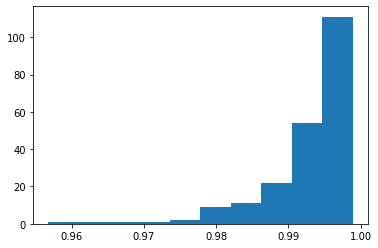

In [23]:
Rs_asd = []
for STR in Z2DF.columns.values:
    r,p = comparebias(Z2DF, ExpZscoreMat, STR, Spark_Meta_ExomeWide["EntrezID"].values)
    Rs_asd.append(r)
plt.hist(Rs_asd)

##### distribution of Z and ASD Zs

In [25]:
Z1Mat = ExpZscoreMat
Z2Mat = Z2DF

In [27]:
#Region = "Prelimbic_area"
topSpecs = []
for g in Z1Mat.index.values:
    exps = [x for x in Z1Mat.loc[g, :].values if x == x]
    exps.sort()
    top5_spec = np.mean(exps[-5:])
    topSpecs.append(top5_spec)

In [33]:
topASDSpecs = []
for g in Spark_Meta_ExomeWide["EntrezID"].values:
    try:
        exps = [x for x in Z1Mat.loc[g, :].values if x == x]
    except:
        continue
    exps.sort()
    top5_spec = np.mean(exps[-5:])
    topASDSpecs.append(top5_spec)

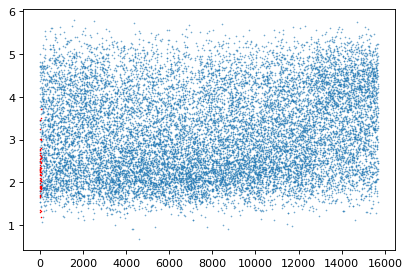

In [36]:
plt.scatter(np.arange(len(topSpecs)), topSpecs, s=0.1)
plt.scatter(np.arange(len(topASDSpecs)), topASDSpecs, s=0.2, color="red", marker="x")

In [37]:
print(np.mean(topSpecs), np.mean(topASDSpecs))

3.1378320300292235 2.2924386920901116


In [60]:
def topNSpect(Mat, GeneSet, topN=5):
    topSpecs = []
    topSelectSpec = []
    idx_all = []
    idx_select = []
    for i, g in enumerate(Mat.index.values):
        exps = [x for x in Mat.loc[g, :].values if x == x]
        exps.sort()
        top5_spec = np.mean(exps[-topN:])
        topSpecs.append(top5_spec)
        idx_all.append(i)
        if g in GeneSet:
            topSelectSpec.append(top5_spec)
            idx_select.append(i)
    return idx_all, topSpecs, idx_select, topSelectSpec

def topNSpecVsExpLevel(MatSpec, MatLevel, GeneSet, topN=5):
    expLevel = []
    topSpecs = []
    topSelectSpec = []
    expLevelSelect = []
    idx_all = []
    idx_select = []
    for i, g in enumerate(MatSpec.index.values):
        spec = [x for x in MatSpec.loc[g, :].values if x == x]
        spec.sort()
        top5_spec = np.mean(spec[-topN:])
        topSpecs.append(top5_spec)
        idx_all.append(i)
        exp = MatLevel.loc[g, :].mean()
        expLevel.append(exp)
        if g in GeneSet:
            topSelectSpec.append(top5_spec)
            idx_select.append(i)
            expLevelSelect.append(exp)
    return idx_all, topSpecs, expLevel, idx_select, topSelectSpec, expLevelSelect

3.1378320300292235 2.292438692090111


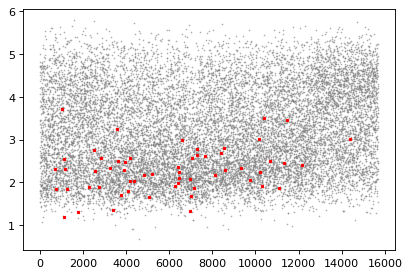

In [86]:
GeneSet = set(Spark_Meta_ExomeWide["EntrezID"].values)
idx_all, topSpecs, expLevel, idx_select, topSelectSpec, expLevelSelect = topNSpecVsExpLevel(Z1Mat, ExpMat, GeneSet, topN=5)
plt.scatter(idx_all, topSpecs, color="grey", s=0.1)
plt.scatter(idx_select, topSelectSpec, s=5, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

SpearmanrResult(correlation=-0.6408478091781178, pvalue=7.892754840126564e-08)


Text(0, 0.5, 'Z1')

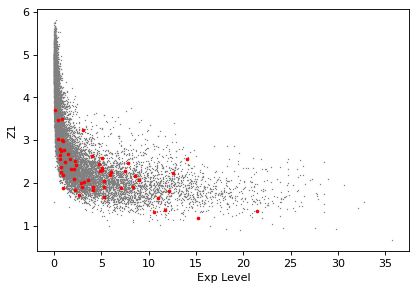

In [87]:
plt.scatter(expLevel, topSpecs, s=0.1, color="grey", marker="x")
plt.scatter(expLevelSelect, topSelectSpec, s=5, color="red", marker="o")
print(spearmanr(expLevelSelect, topSelectSpec))
plt.xlabel("Exp Level")
plt.ylabel("Z1")

3.05043033892496 2.266996834576874


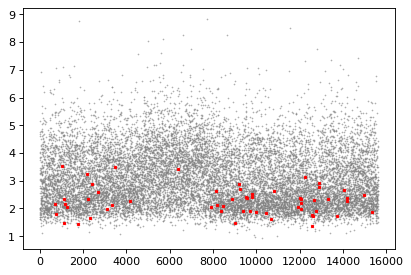

In [154]:
GeneSet = set(Spark_Meta_ExomeWide["EntrezID"].values)
idx_all, topSpecs, expLevel, idx_select, topSelectSpec, expLevelSelect = topNSpecVsExpLevel(Z2Mat, ExpMat, GeneSet, topN=5)
plt.scatter(idx_all, topSpecs, s=0.1, color="grey")
plt.scatter(idx_select, topSelectSpec, s=5, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

In [155]:
sibling_genes = pd.read_csv("dat/sibling_match.csv", index_col=0).index.values
idx_all, topSpecs, expLevel, idx_select2, topSelectSpec2, expLevelSelect2 = topNSpecVsExpLevel(
    Z2Mat, ExpMat, sibling_genes, topN=5)

In [165]:
def MoveingAvg2(Percents, Mut_Den, l): 
    res = []
    last_v = 0
    for i, v in enumerate(l[:]):
        res.append([])
        for j, percent in enumerate(Percents):
            if percent > last_v and percent <= v:
                res[i].append(Mut_Den[j])
        last_v = v
    return res

In [169]:
l = np.arange(0, 40, 5)
res = MoveingAvg2(expLevelSelect, topSelectSpec, l)
res2 = MoveingAvg2(expLevelSelect2, topSelectSpec2, l)

In [186]:
def eeee(expLevelSelect, topSelectSpec, expLevelSelect2, topSelectSpec2, cutoff=1):
    xx1, xx2 = [], []
    yy1, yy2 = [], []
    for level, bias in zip(expLevelSelect, topSelectSpec):
        if level > cutoff:
            xx2.append(bias)
        else:
            xx1.append(bias)
    for level, bias in zip(expLevelSelect2, topSelectSpec2):
        if level > cutoff:
            yy2.append(bias)
        else:
            yy1.append(bias)
    print(np.mean(topSelectSpec), np.mean(xx1), np.mean(xx2))
    print(np.mean(topSelectSpec2), np.mean(yy1), np.mean(yy2))
eeee(expLevelSelect, topSelectSpec, expLevelSelect2, topSelectSpec2, cutoff=1)

2.266996834576874 2.793989070235078 2.095417967153273
2.961312675728151 3.6315399386921654 2.1949286105830046


SpearmanrResult(correlation=-0.6680062224526835, pvalue=1.3724882155085318e-08)


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Expression Bias')

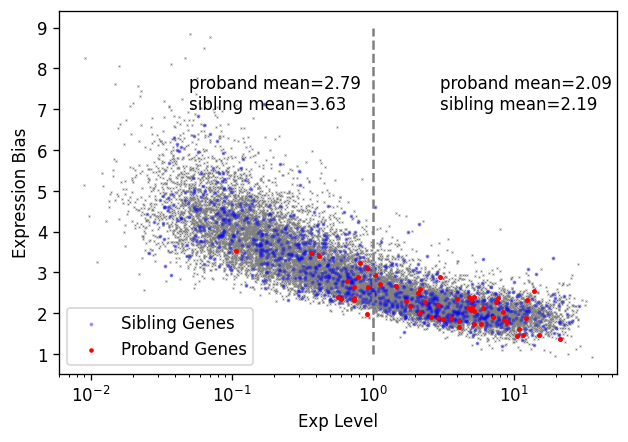

In [193]:
fig, ax = plt.subplots(dpi=120)
ax.scatter(expLevel, topSpecs, s=0.1, color="grey", marker="x")
ax.scatter(expLevelSelect, topSelectSpec, s=3, color="red", marker="o")
ax.scatter(expLevelSelect2, topSelectSpec2, s=2, color="blue", marker="o", alpha=0.3, 
            label="Sibling Genes")
ax.scatter(expLevelSelect, topSelectSpec, s=3, color="red", marker="o", 
            label="Proband Genes")
#plt.plot(l, res, color="red")
#plt.plot(l, res2, color="blue")
ax.annotate(xy=(0.05,7), s="proband mean=2.79\nsibling mean=3.63")
ax.annotate(xy=(3,7), s="proband mean=2.09\nsibling mean=2.19")
ax.vlines(ymin=1, ymax=9, x=1, color="grey", ls="dashed")
print(spearmanr(expLevelSelect, topSelectSpec))
ax.set_xlabel("Exp Level")
ax.set_xscale('log')
plt.legend(loc="lower left")
ax.set_ylabel("Expression Bias")

3.1378320300292235 2.292438692090111


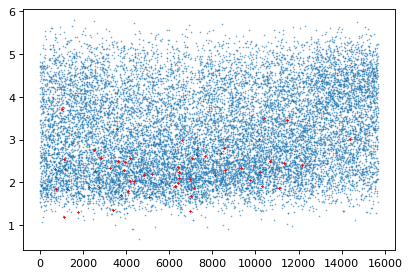

In [50]:
GeneSet = set(Spark_Meta_ExomeWide["EntrezID"].values)
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z1Mat, GeneSet, topN=5)
plt.scatter(idx_all, topSpecs, s=0.1)
plt.scatter(idx_select, topSelectSpec, s=1, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

4.203061842263978 2.812113859611011


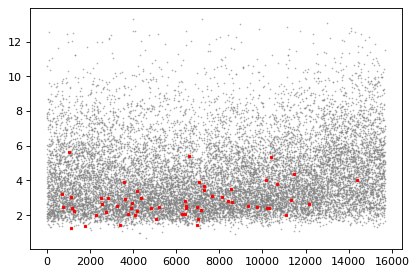

In [78]:
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z1Mat, GeneSet, topN=1)
plt.scatter(idx_all, topSpecs, s=0.1, color="grey")
plt.scatter(idx_select, topSelectSpec, s=5, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

1.3584188933520351 1.3151789019631146


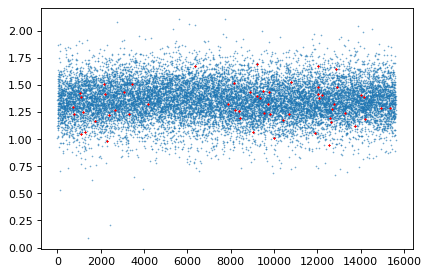

In [56]:
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z2Mat, GeneSet, topN=50)
plt.scatter(idx_all, topSpecs, s=0.1)
plt.scatter(idx_select, topSelectSpec, s=1, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

3.985065191851969 2.691383186262775


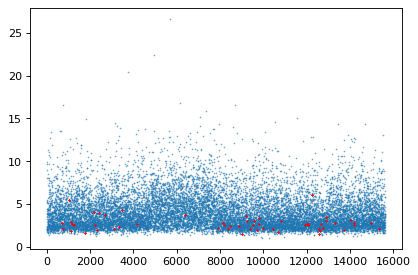

In [53]:
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z2Mat, GeneSet, topN=1)
plt.scatter(idx_all, topSpecs, s=0.1)
plt.scatter(idx_select, topSelectSpec, s=1, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

# Pvalue for Zmean from sib

In [71]:
EFFECTS = []
for i in range(1000):
    tmp = ssc_sib.sample(n=101)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, Sib_sample101, Method=1)
    effect = np.array(Sib_avgZ1["EFFECT"].values)
    EFFECTS.append(effect)
EFFECTS = np.array(EFFECTS)

In [73]:
np.save("dat/bias/effects_sib.nparr", EFFECTS)

In [75]:
EFFECTS.shape

(1000, 213)

(array([  4.,  23.,  66., 168., 272., 256., 135.,  53.,  18.,   5.]),
 array([-0.03107105, -0.0233376 , -0.01560414, -0.00787069, -0.00013723,
         0.00759623,  0.01532968,  0.02306314,  0.0307966 ,  0.03853005,
         0.04626351]),
 <a list of 10 Patch objects>)

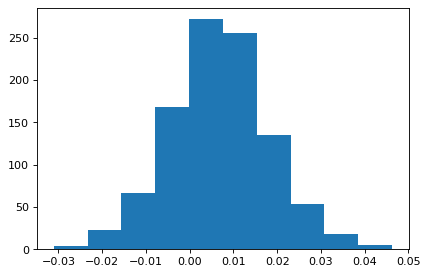

In [90]:
plt.hist(EFFECTS[:, 100])

In [91]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS[:, i], effect)
    else:
        pvalue = GetPermutationP(EFFECTS[:, i], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue

In [92]:
Meta_Zscore.to_csv('dat/bias/test.csv')

## De novo Simulations

In [95]:
denovo_simulations = pd.read_csv("dat/meta_denovo_simulations.csv", index_col = "index")
denovo_simulations.head(2)

,1,2,131076,12,13,14,15,16,18,163859,...,196513,196527,196528,196541,163782,163786,6503,131034,327657,201895
index,,,,,,,,,,,,,,,,,,,,,
0,"0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,1","1,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
1,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","1,0","0,1","0,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0"


In [129]:
def sim_denovo_row2gweight(row, n_gene=101, LGD_Weight = 0.357, DMIS_Weight = 0.231):
    dat = []
    for index, value in row.items():
        N_lgd, N_dmis = map(int, value.split(","))
        #print(index, N_lgd, N_dmis)
        if N_lgd + N_dmis == 0:
            continue
        dat.append([index, N_lgd, N_dmis, N_lgd * LGD_Weight + N_dmis * DMIS_Weight])
    df = pd.DataFrame(data=dat, columns=["Entrez", "NLGD", "NDmis", "Weight"])
    df = df.sort_values("Weight", ascending=False)
    top = df.head(n_gene)
    return dict(zip([int(x) for x in top["Entrez"].values], top["Weight"].values))

In [132]:
EFFECTS = []
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    effect = np.array(sim_avgZ1["EFFECT"].values)
    EFFECTS.append(effect)
EFFECTS = np.array(EFFECTS)

In [133]:
np.save("dat/bias/effects_sim.nparr", EFFECTS)

In [134]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS[:, i], effect)
    else:
        pvalue = GetPermutationP(EFFECTS[:, i], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
Meta_Zscore.to_csv('dat/bias/test.csv')

(array([ 36., 139., 232., 246., 180.,  86.,  51.,  18.,   9.,   3.]),
 array([0.05159681, 0.0607005 , 0.06980418, 0.07890787, 0.08801156,
        0.09711525, 0.10621894, 0.11532263, 0.12442632, 0.13353001,
        0.1426337 ]),
 <a list of 10 Patch objects>)

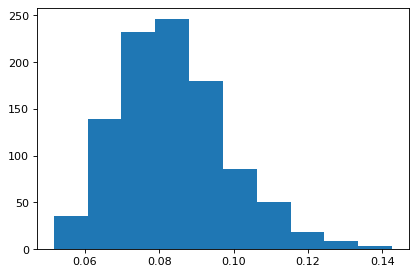

In [139]:
plt.hist(EFFECTS[:, 50])

(array([ 4.,  4., 21., 46., 51., 50., 22.,  8.,  5.,  2.]),
 array([-0.38713945, -0.30449129, -0.22184313, -0.13919496, -0.0565468 ,
         0.02610136,  0.10874952,  0.19139768,  0.27404584,  0.356694  ,
         0.43934216]),
 <a list of 10 Patch objects>)

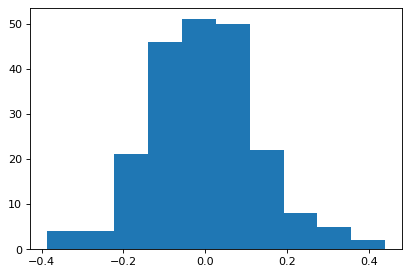

In [140]:
plt.hist(EFFECTS[1, :])

In [143]:
## Dist as same STR
EFFECTS2 = {}
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    for STR, row in sim_avgZ1.iterrows():
        #print(STR, EFFECT)
        if STR in EFFECTS2:
            EFFECTS2[STR].append(row["EFFECT"])
        else:
            EFFECTS2[STR] = [row["EFFECT"]]

In [145]:
#EFFECTS2[]
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS2[_str], effect)
    else:
        pvalue = GetPermutationP(EFFECTS2[_str], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
Meta_Zscore.to_csv('dat/bias/test2.csv')

In [193]:
dat = []
for k, v in EFFECTS2.items():
    dat.append([k, np.mean(v), np.var(v)])
null = pd.DataFrame(data=dat, columns=["STR", "MEAN", "VAR"])
null = null.sort_values("MEAN", ascending=False)
null.index = null["STR"].values

In [194]:
null

,STR,MEAN,VAR
Anterior_pretectal_nucleus,Anterior_pretectal_nucleus,0.250317,0.009316
Inferior_colliculus_central_nucleus,Inferior_colliculus_central_nucleus,0.196168,0.008804
Inferior_colliculus_external_nucleus,Inferior_colliculus_external_nucleus,0.195882,0.009545
Nucleus_of_the_optic_tract,Nucleus_of_the_optic_tract,0.184289,0.008402
Lateral_posterior_nucleus_of_the_thalamus,Lateral_posterior_nucleus_of_the_thalamus,0.159468,0.008886
...,...,...,...
Retrochiasmatic_area,Retrochiasmatic_area,-0.147751,0.006912
Substantia_nigra_compact_part,Substantia_nigra_compact_part,-0.162306,0.007995
Nucleus_raphe_magnus,Nucleus_raphe_magnus,-0.168415,0.008699
Tuberal_nucleus,Tuberal_nucleus,-0.168593,0.007232


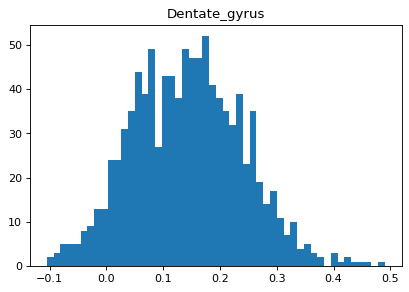

In [238]:
plt.hist(EFFECTS2["Dentate_gyrus"], bins=50)
plt.title("Dentate_gyrus")
plt.show()

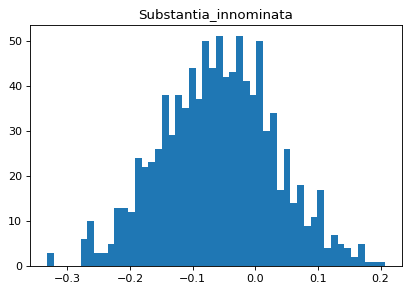

In [239]:
plt.hist(EFFECTS2["Substantia_innominata"], bins=50)
plt.title("Substantia_innominata")
plt.show()

In [195]:
STR2REG = STR2Region()
for i, row in null.iterrows():
    null.loc[i, "REG"] = STR2REG[row["STR"]]

In [196]:
null.head(5)

,STR,MEAN,VAR,REG
Anterior_pretectal_nucleus,Anterior_pretectal_nucleus,0.250317,0.009316,Midbrain
Inferior_colliculus_central_nucleus,Inferior_colliculus_central_nucleus,0.196168,0.008804,Midbrain
Inferior_colliculus_external_nucleus,Inferior_colliculus_external_nucleus,0.195882,0.009545,Midbrain
Nucleus_of_the_optic_tract,Nucleus_of_the_optic_tract,0.184289,0.008402,Midbrain
Lateral_posterior_nucleus_of_the_thalamus,Lateral_posterior_nucleus_of_the_thalamus,0.159468,0.008886,Thalamus


In [197]:
REGs = list(set(null["REG"].values))

In [227]:
dat = []
for reg in REGs:
    dat.append([reg, np.mean(null[null["REG"]==reg]["MEAN"].values)])
torank = pd.DataFrame(data=dat, columns=["REG", "MEAN"])
torank = torank.sort_values("MEAN")
torank.head(2)
REGs = torank["REG"].values

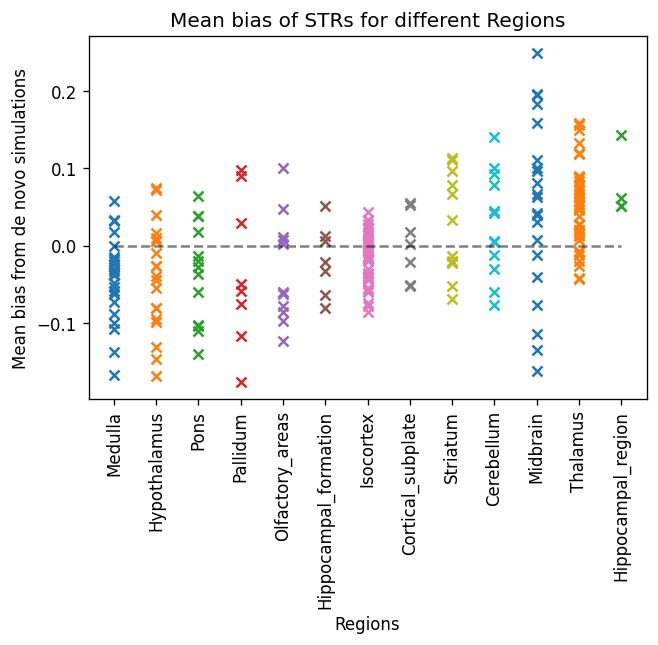

In [228]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["MEAN"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=0, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Mean bias of STRs for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Mean bias from de novo simulations")
plt.show()

In [240]:
mean_var = null["VAR"].mean()

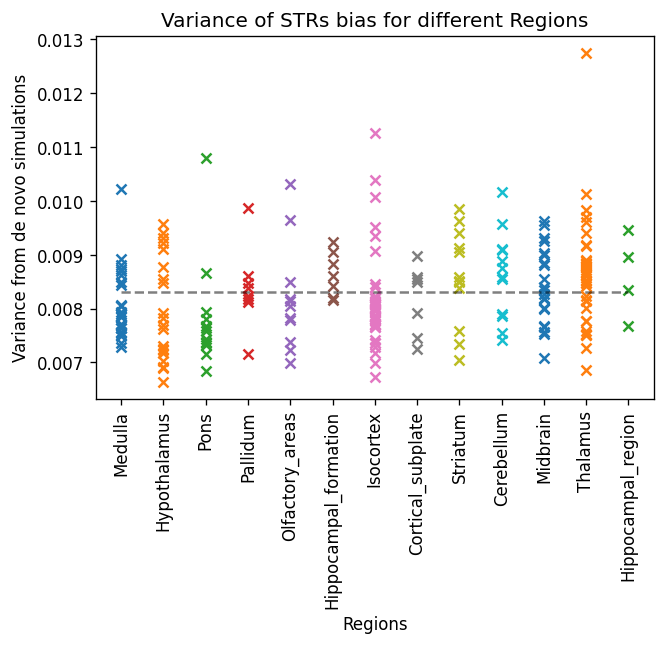

In [242]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["VAR"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=mean_var, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Variance of STRs bias for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Variance from de novo simulations")
plt.show()

In [201]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS2[_str], effect)
    else:
        pvalue = GetPermutationP(EFFECTS2[_str], effect, gt = False)
    new_effect = effect - null.loc[_str, "MEAN"]
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
    Meta_Zscore.loc[_str, "EFFECT2"] = new_effect
Meta_Zscore.to_csv('dat/bias/test3.csv')

In [ ]:
## Qunatils checking

In [205]:
ExpZscoreMat.head(2)

,Anterior_amygdalar_area,Anterior_cingulate_area_dorsal_part,Anterior_cingulate_area_ventral_part,Nucleus_accumbens,Anterodorsal_nucleus,Anterior_hypothalamic_nucleus,Agranular_insular_area_dorsal_part,Agranular_insular_area_posterior_part,Agranular_insular_area_ventral_part,Nucleus_ambiguus,...,Primary_visual_area,Posterolateral_visual_area,posteromedial_visual_area,Ventral_medial_nucleus_of_the_thalamus,Ventromedial_hypothalamic_nucleus,Ventral_posterolateral_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,Ventral_tegmental_area,Hypoglossal_nucleus
ROW,,,,,,,,,,,,,,,,,,,,,
1,0.160640,-0.539153,-0.504043,-0.761513,-0.693056,1.644456,-0.925718,NaN,-0.445816,-0.491676,...,-0.826146,1.096054,-1.042356,-0.149321,1.309056,-0.090982,0.224140,-0.079631,1.733742,0.713978
2,-0.476558,-0.559858,-0.517535,-0.524070,0.155116,-0.414605,-0.132720,-0.366087,-0.228981,-0.431621,...,-0.477847,-0.507564,-0.227819,-0.304092,-0.342912,-0.505963,-0.469515,-0.360610,-0.054245,1.149715


In [ ]:
ExpZscoreMat

In [219]:
def get_percentile(STR, MAT = ExpZscoreMat, P=[10, 50, 90]):
    values = MAT[STR].values
    values = [x for x in values if x==x]
    res = []
    for p in P:
        res.append(np.percentile(values, q=p))
    return res

In [220]:
print(get_percentile("Anterior_amygdalar_area"))
print(get_percentile("Anterior_cingulate_area_dorsal_part"))
print(get_percentile("Anterior_cingulate_area_ventral_part"))
print(get_percentile("Ventral_tegmental_area"))

[-1.0036701566616328, -0.188189282385728, 1.2515600583166464]
[-1.0036701565866828, -0.18818928298236598, 1.2515600524549726]
[-1.0036702236757309, -0.18818928405823449, 1.251565298976829]
[-1.0036701846273999, -0.18818834763392, 1.2515622453055562]


In [246]:
denovo_simulations.head(2)

,1,2,131076,12,13,14,15,16,18,163859,...,196513,196527,196528,196541,163782,163786,6503,131034,327657,201895
index,,,,,,,,,,,,,,,,,,,,,
0,"0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,1","1,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
1,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","1,0","0,1","0,0",...,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0"


### P value for expression level

In [265]:
## Construct expression match matrix
#denovo_simulations.head(2)
dat = []
_dir = "dat/Match_Volume_W/"
_index = np.empty(0)
no_g = []
for g in denovo_simulations.columns.values:
    try:
        tmp = loadgenelist(_dir + str(g) + ".txt.gz")
    except:
        no_g.append(g)
    dat.append(tmp)
    _index = np.append(_index, g)
Sim_Denovo_Matching = pd.DataFrame(data=dat, index=_index)

In [266]:
Sim_Denovo_Matching.head(2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,23581,162605,152687,9245,131540,915,130162,285172,219432,254013,...,9702,389336,6557,167555,126282,368,5330,8406,79589,130589
2,54971,2297,1842,117145,51360,1293,54881,56927,84725,3290,...,2651,4739,5317,146852,3655,83894,6780,92002,54457,3589


In [253]:
print(no_g)

['100499483', '100996939', '100505591', '100505993', '100506049', '100506564', '100506581', '100506658', '100506736', '100310846', '100288797', '101928601']


In [259]:
Sim_Denovo_Matching.index

Index(['1', '2', '131076', '12', '13', '14', '15', '16', '18', '163859',
       ...
       '196513', '196527', '196528', '196541', '163782', '163786', '6503',
       '131034', '327657', '201895'],
      dtype='object', length=13752)

In [268]:
Sim_Denovo_Matching.loc['54971', :]

0       64801
1       27131
2       85441
3       92002
4        5449
        ...  
995      5978
996     79134
997     25855
998    253714
999     84725
Name: 54971, Length: 1000, dtype: int64

In [ ]:
## Dist as same STR
EFFECTS2 = {}
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    
    #sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    #for STR, row in sim_avgZ1.iterrows():
        #print(STR, EFFECT)
    #    if STR in EFFECTS2:
    #        EFFECTS2[STR].append(row["EFFECT"])
    #    else:
    #        EFFECTS2[STR] = [row["EFFECT"]]

In [269]:
DIR = "/Users/jiayao/Work/ASD_Circuits/src/dat/bias/DNV_SM_ExpLevel/"
EXP_LEVEL_EFFECT = {}
for i in range(1000):
    tmp_df = pd.read_csv("{}/dnv_sm.{}.csv".format(DIR, i), index_col="STR")
    for STR, row in tmp_df.iterrows():
        #print(STR, EFFECT)
        if STR in EXP_LEVEL_EFFECT:
            EXP_LEVEL_EFFECT[STR].append(row["EFFECT"])
        else:
            EXP_LEVEL_EFFECT[STR] = [row["EFFECT"]]

In [271]:
dat = []
for k, v in EXP_LEVEL_EFFECT.items():
    dat.append([k, np.mean(v), np.var(v)])
null = pd.DataFrame(data=dat, columns=["STR", "MEAN", "VAR"])
null = null.sort_values("MEAN", ascending=False)
null.index = null["STR"].values

In [272]:
STR2REG = STR2Region()
for i, row in null.iterrows():
    null.loc[i, "REG"] = STR2REG[row["STR"]]
REGs = list(set(null["REG"].values))  
dat = []
for reg in REGs:
    dat.append([reg, np.mean(null[null["REG"]==reg]["MEAN"].values)])
torank = pd.DataFrame(data=dat, columns=["REG", "MEAN"])
torank = torank.sort_values("MEAN")
torank.head(2)
REGs = torank["REG"].values

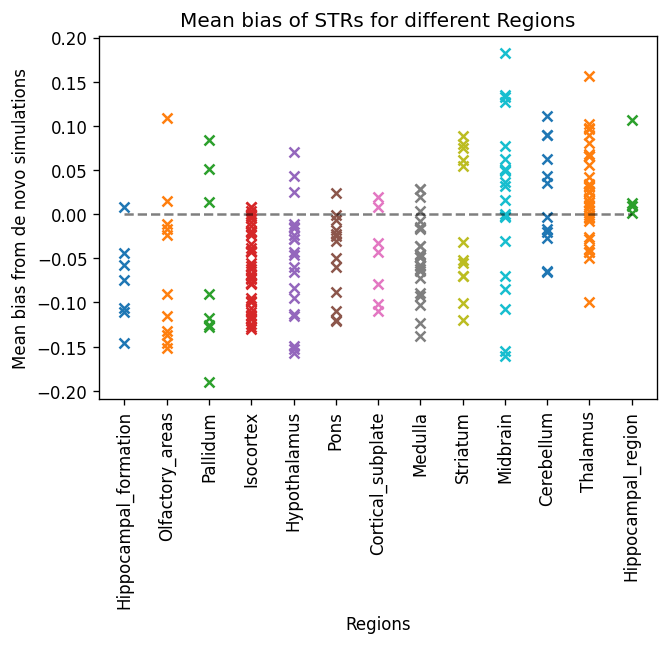

In [273]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["MEAN"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=0, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Mean bias of STRs for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Mean bias from de novo simulations")
plt.show()

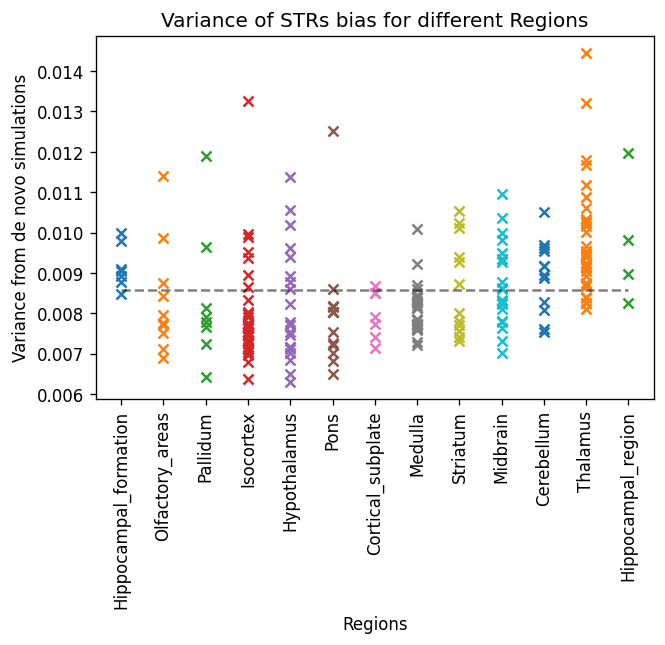

In [274]:
mean_var = null["VAR"].mean()
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["VAR"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=mean_var, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Variance of STRs bias for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Variance from de novo simulations")
plt.show()

In [276]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.explevel.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EXP_LEVEL_EFFECT[_str], effect)
    else:
        pvalue = GetPermutationP(EXP_LEVEL_EFFECT[_str], effect, gt = False)
    new_effect = effect - null.loc[_str, "MEAN"]
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
    Meta_Zscore.loc[_str, "EFFECT2"] = new_effect
Meta_Zscore.to_csv('dat/bias/test4.csv')

# Compare 3 different method for sepcificity bias

In [2]:
Aggregate = pd.read_csv("../dat/genes/asd/DenovoWEST_TADA.txt", delimiter="\t")
Aggregate['pDenovoWEST'] = pd.to_numeric(Aggregate["pDenovoWEST"], errors='coerce')
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, out = "dat/bias2/meta.gene.weights.csv")
Agg_match_df = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.new.csv", index_col="GENE")
print(len(Agg_gene2MutN))

101


In [39]:
Agg_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=1,
                                              csv_fil = "dat/bias3/Agg.AvgZ1.Mutcount.bias.csv")

41


In [12]:
Agg_avgZ2 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=2, Match_DF=Agg_match_df, 
                                              csv_fil = "dat/bias3/Agg.AvgZ2.Mutcount.bias.csv")

39


In [15]:
Agg_avgZ3 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=3, Match_DF=Agg_match_df, 
                                              csv_fil = "dat/bias3/Agg.AvgZ3.Mutcount.bias.csv")

38


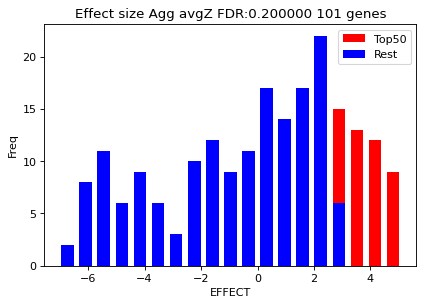

In [40]:
PlotEffectDist(Agg_avgZ3, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

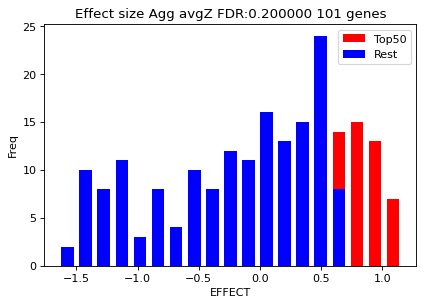

In [20]:
PlotEffectDist(Agg_avgZ2, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

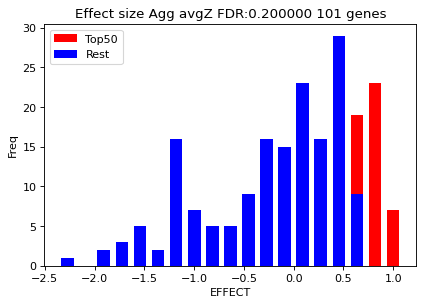

In [21]:
PlotEffectDist(Agg_avgZ1, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [17]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ3.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Rhomboid_nucleus; Mediodorsal_nucleus_of_thalamus
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Anterior_cingulate_area_dorsal_part; Anteromedial_visual_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Agranular_insular_area_ventral_part; Secondary_motor_area; Gustatory_areas; Visceral_area; Lateral_visual_area; Dorsal_auditory_area; Posterior_parietal_association_areas; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Posterolateral_visual_area
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Olfactory_areas 	 4 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory

In [18]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ2.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 6 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus
Isocortex 	 21 	 Orbital_area_lateral_part; Prelimbic_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Retrosplenial_area_lateral_agranular_part; Primary_motor_area; Secondary_motor_area; Gustatory_areas; Visceral_area; Agranular_insular_area_ventral_part; Dorsal_auditory_area; Orbital_area_medial_part; Lateral_visual_area; Primary_somatosensory_area_trunk; Posterior_parietal_association_areas; Agranular_insular_area_posterior_part; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum; Presubiculum
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_pedun

In [19]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ1.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 8 	 Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Parafascicular_nucleus; Nucleus_of_reuniens; Intermediodorsal_nucleus_of_the_thalamus; Paraventricular_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Submedial_nucleus_of_the_thalamus
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Dorsal_auditory_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_visual_area; Primary_somatosensory_area_lower_limb; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_posterior_part; Retrosplenial_area_lateral_agranular_part; Visceral_area; Secondary_motor_area; Orbital_area_medial_part; Primary_motor_area; Lateral_visual_area; Posterolateral_visual_area; Agranular_insular_area_ventral_part; Gustatory_areas; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Su

# For Method 3, Does it able to normlize gene set size?

In [23]:
ssc_all = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/Supplementary_Table_7.xlsx")
ssc_sib = ssc_all[(ssc_all["dnv_LGDs_sib"]!=0) | (ssc_all["dnv_missense_sib"]!=0)]

In [24]:
ssc_sib.shape

(1215, 29)

In [25]:
tmp = ssc_sib.sample(n=101)

In [26]:
tmp.shape

(101, 29)

In [32]:
def sibling_gene_weight(df):
    gene2MutN = {}
    for i, row in df.iterrows():
        try:
            g = GeneSymbol2Entrez[row["gene"]]
            gene2MutN[g] = row["dnv_LGDs_sib"]*0.375 + (row["dnv_missense_sib"]) * 0.145
        except:
            continue
    return gene2MutN

In [41]:
tmp = ssc_sib.sample(n=101)
Sib_sample101 = sibling_gene_weight(tmp)
print(len(Sib_sample101))

94


In [42]:
Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1,
                                              csv_fil = "dat/bias3/Sib.AvgZ1.Mutcount.bias.csv")

35


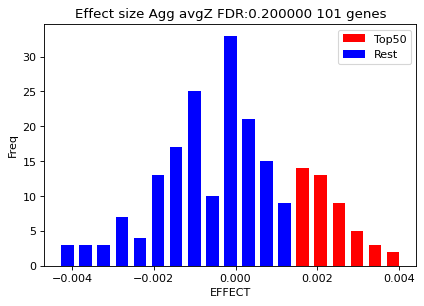

In [43]:
PlotEffectDist(Sib_avgZ1, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [48]:
for i in range(10):
    tmp = ssc_sib.sample(n=101)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.0019389413868474712 5.378630752479766e-07
0.00212888363670234 1.7775576724506274e-06
0.0016110278965608001 1.3050112890064857e-06
0.0019358141239947896 5.760567288389296e-07
0.0022852619988945146 7.708278715898236e-07
0.0031768258531090377 2.2397084615744967e-06
0.0023976437120662992 7.834306513733399e-07
0.002349322249294572 1.029242751347744e-06
0.0020237881053463396 2.221745386863179e-06
0.0019175731271255324 5.128107621677241e-07


In [49]:
for i in range(10):
    tmp = ssc_sib.sample(n=51)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.0056178484525570005 2.7923883679755892e-06
0.0063490141009708775 6.71122461813859e-06
0.006272680032825859 7.2703626914502964e-06
0.004640283704860911 9.524726181487976e-06
0.007033120044551493 3.6697212756592134e-05
0.0053330014479219855 4.446320349635775e-06
0.004881409060390986 3.2799961958770596e-06
0.008129327437749478 2.2443012497996824e-05
0.005829531961867925 7.041011879232908e-06
0.006899409318098098 1.1198934525975897e-05


In [50]:
for i in range(10):
    tmp = ssc_sib.sample(n=200)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.001100446505943761 2.988754348972949e-07
0.0011642074229136932 7.341448714940769e-07
0.0010108115411336094 4.5438772774939387e-07
0.0007369056751881707 2.392685044830714e-07
0.0007036137265139063 5.696060924448429e-08
0.00099602873182754 3.12551865580685e-07
0.0008208283876010277 2.821142591447742e-07
0.0006866171908992538 1.9505664913639837e-07
0.0010822239264682272 1.9859062228758234e-07
0.0008399816450629278 1.6045526842913665e-07


In [ ]:
print("hj")

In [56]:
Sib_match = Agg_match_df = pd.read_csv("dat/matching/asd_sib_exp_matches_1000.csv", index_col="GENE")

In [58]:
tmp = ssc_sib.sample(n=51)
Sib_sample51 = sibling_gene_weight(tmp)
Sib_avgZ3_51 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample51, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_51.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

230.46532803896204 4366.858251996743


In [59]:
tmp = ssc_sib.sample(n=101)
Sib_sample101 = sibling_gene_weight(tmp)
Sib_avgZ3_101 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_101.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

47.95358833527919 498.3731183045462


In [60]:
tmp = ssc_sib.sample(n=201)
Sib_sample201 = sibling_gene_weight(tmp)
Sib_avgZ3_201 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample201, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_201.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

24.469691297297096 160.61366363201324
